## IMPORTS

In [1]:
import json
import os
import gc
import pickle
from datetime import datetime
from glob import glob
from tqdm.notebook import tqdm
import warnings
# warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'
pd.set_option("display.precision", 2)

In [49]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import mean_absolute_error

In [4]:
from bs4 import BeautifulSoup

---

## CONSTANTS

In [5]:
PATH_TO_DATA = "../data/"

---

## DATA EXTRACTION

### feature extraction functions

The following code will help to throw away all HTML tags from an article content.

In [ ]:
from html.parser import HTMLParser


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return "".join(self.fed)


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [ ]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(" ")[-1].replace(")", ""))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = " "
        new_line = "".join(new_line)
        return read_json_line(line=new_line)
    return result

Parse JSON and extract some features.

In [ ]:
def extract_features(path_to_data):
    
    content_list = [] 
    published_list = [] 
    title_list = []
    author_list = []
    domain_list = []
    tags_list = []
    url_list = []
    
    with open(path_to_data, encoding='utf-8') as inp_json_file:
        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            published = json_data['published']['$date']
            published_list.append(published) 
            #'Medium Terms of Service – Medium Policy – Medium'
            title = json_data['meta_tags']['title'].split('\u2013')[0].strip() 
            title_list.append(title) 
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author) 
            domain = json_data['domain']
            domain_list.append(domain)
            url = json_data['url']
            url_list.append(url)
            
            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = 'None'
            tags_list.append(tags)
            
    df = pd.DataFrame()
    df['content'] = content_list
    df['published'] = pd.to_datetime(published_list, 
                                     format='%Y-%m-%dT%H:%M:%S.%fZ')
    df['title'] = title_list
    df['author'] = author_list
    df['domain'] = domain_list
    df['tags'] = tags_list
    df['length'] = df['content'].apply(len)
    df['url'] = url_list
            
    return df

---

### feature extraction

In [ ]:
%%time
train_df = extract_features(os.path.join(PATH_TO_DATA, 'train.json'))

In [ ]:
%%time
test_df = extract_features(os.path.join(PATH_TO_DATA, 'test.json'))

In [ ]:
train_df.to_csv('../data/train-test/train.csv')
test_df.to_csv('../data/train-test/test.csv')

## READ CSV

In [6]:
%%time
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train-test/train.csv'), index_col=0)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train-test/test.csv'), index_col=0)

CPU times: user 12.4 s, sys: 4.11 s, total: 16.5 s
Wall time: 19.7 s


In [7]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), index_col='id')
train_target = train_target['log_recommends'].values

In [8]:
print("TRAIN SET")
display(train_df.head(2))

print("TEST SET")
display(test_df.head(2))

TRAIN SET


,content,published,title,author,domain,tags,length,url
0,"MediumEveryone’s stories and ideasAug 13, 2012...",2012-08-13 22:54:53.510,Medium Terms of Service,Medium,medium.com,TermsAndConditions Terms Medium,6933,https://medium.com/policy/medium-terms-of-serv...
1,"MediumEveryone’s stories and ideasAug 2, 2015 ...",2015-08-03 07:44:50.331,Amendment to Medium Terms of Service Applicabl...,Medium,medium.com,NaN,10737,https://medium.com/policy/amendment-to-medium-...


TEST SET


,content,published,title,author,domain,tags,length,url
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...
1,Member previewMaria Bustillosis a journalist a...,2017-12-07 15:56:00.967,Blockchain is Memory,Maria Bustillos,medium.com,Blockchain Technology History Network WordsTha...,6703,https://medium.com/wordsthatmatter/never-break...


In [9]:
train_df.info()
# main observations:
# 1. published must be changed to datetime format 
# 2. url must be changed to string

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62313 entries, 0 to 62312
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    62313 non-null  object
 1   published  62313 non-null  object
 2   title      62313 non-null  object
 3   author     62313 non-null  object
 4   domain     62313 non-null  object
 5   tags       56473 non-null  object
 6   length     62313 non-null  int64 
 7   url        62313 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.3+ MB


In [10]:
test_df.info()
# same changes need to be applied as to train_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34645 entries, 0 to 34644
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    34645 non-null  object
 1   published  34645 non-null  object
 2   title      34645 non-null  object
 3   author     34645 non-null  object
 4   domain     34645 non-null  object
 5   tags       34011 non-null  object
 6   length     34645 non-null  int64 
 7   url        34645 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


In [11]:
# creating full_df so that we may not duplicate code
idx_split = len(train_df)
full_df = pd.concat([train_df, test_df])
full_df['published'] = pd.to_datetime(full_df['published'])
full_df['tags'] = full_df['tags'].astype('str')

In [12]:
# adding new features
full_df['day_of_week'] = full_df['published'].apply(lambda x: x.dayofweek)
full_df['year'] = full_df['published'].apply(lambda x: x.year)
full_df['month'] = full_df['published'].apply(lambda x: x.month)
full_df['hour'] = full_df['published'].apply(lambda x: x.hour)
full_df['number_of_tags'] = full_df['tags'].apply(lambda x: len(x.split()))

In [13]:
# separating
train_df = full_df.iloc[:idx_split, :]
test_df = full_df.iloc[idx_split:, :]
del full_df

In [14]:
train_df.loc[:,'claps'] = train_target.copy()
train_df.sort_values(by='published', inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [15]:
print('TRAIN: {}'.format(train_df.shape))
print('TEST: {}'.format(test_df.shape))

TRAIN: (62313, 14)
TEST: (34645, 13)


In [16]:
# removing garbage from memory
gc.collect()

60

## EDA

In [17]:
# 5 earliest articles on Medium.com
train_df.head()

,content,published,title,author,domain,tags,length,url,day_of_week,year,month,hour,number_of_tags,claps
0,Susan BrattonTrusted Hot Sex Advisor To Millio...,1970-01-01 00:00:00.001,Saving Your Marriage By Watching Steamy Sex Ed...,Susan Bratton,medium.com,Lovemaking Sex SexPositions EarlyBird SexEdVideos,5473,http://personallifemedia.com/2017/01/saving-ma...,3,1970,1,0,5,1.10
1,"Ryo OoishiDec 31, 1969やってよかった中学受験明日から息子の中学受験がは...",1970-01-01 00:00:00.001,やってよかった中学受験,Ryo Ooishi,medium.com,nan,5325,https://medium.com/@ooishi/%E3%82%84%E3%81%A3%...,3,1970,1,0,1,2.56
2,なぞちゅう仮面ライダーとかスーパー戦隊を愛する30代。特撮はたしなむ程度（自称）色々なもの、...,1970-01-18 03:21:32.400,はてなブログに書いた今年の手帳のお話,なぞちゅう,medium.com,徒然日記 手帳 ブログ,2487,http://nazoblackrx.hatenablog.com/entry/2016/1...,6,1970,1,3,3,0.69
3,"Internet Corporation LLCDec 8, 1987SPECIAL NOT...",1987-12-08 21:45:00.000,Internet Corporation LLC to Acquire Early Clue...,Internet Corporation LLC,medium.com,SocialMedia EarlyClues InternetCorporationLlc,11285,https://medium.com/the-internet-corporation/de...,1,1987,12,21,3,1.10
4,"Mackenzie OldridgeDec 29, 2003g sowtwaretradin...",2003-12-29 17:00:00.000,g sowtwaretrading botMoneyMoneyMakeGetting To ...,Mackenzie Oldridge,medium.com,Finance Trading,12541,http://www.investopedia.com/articles/optioninv...,0,2003,12,17,2,3.53


Main observations: 
1. Time series (year, month, day of week, hour)
2. Domain names
3. Authors
4. Content length
5. Tags

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62313 entries, 0 to 62312
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   content         62313 non-null  object        
 1   published       62313 non-null  datetime64[ns]
 2   title           62313 non-null  object        
 3   author          62313 non-null  object        
 4   domain          62313 non-null  object        
 5   tags            62313 non-null  object        
 6   length          62313 non-null  int64         
 7   url             62313 non-null  object        
 8   day_of_week     62313 non-null  int64         
 9   year            62313 non-null  int64         
 10  month           62313 non-null  int64         
 11  hour            62313 non-null  int64         
 12  number_of_tags  62313 non-null  int64         
 13  claps           62313 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(6)


First articles were published 50 years ago.

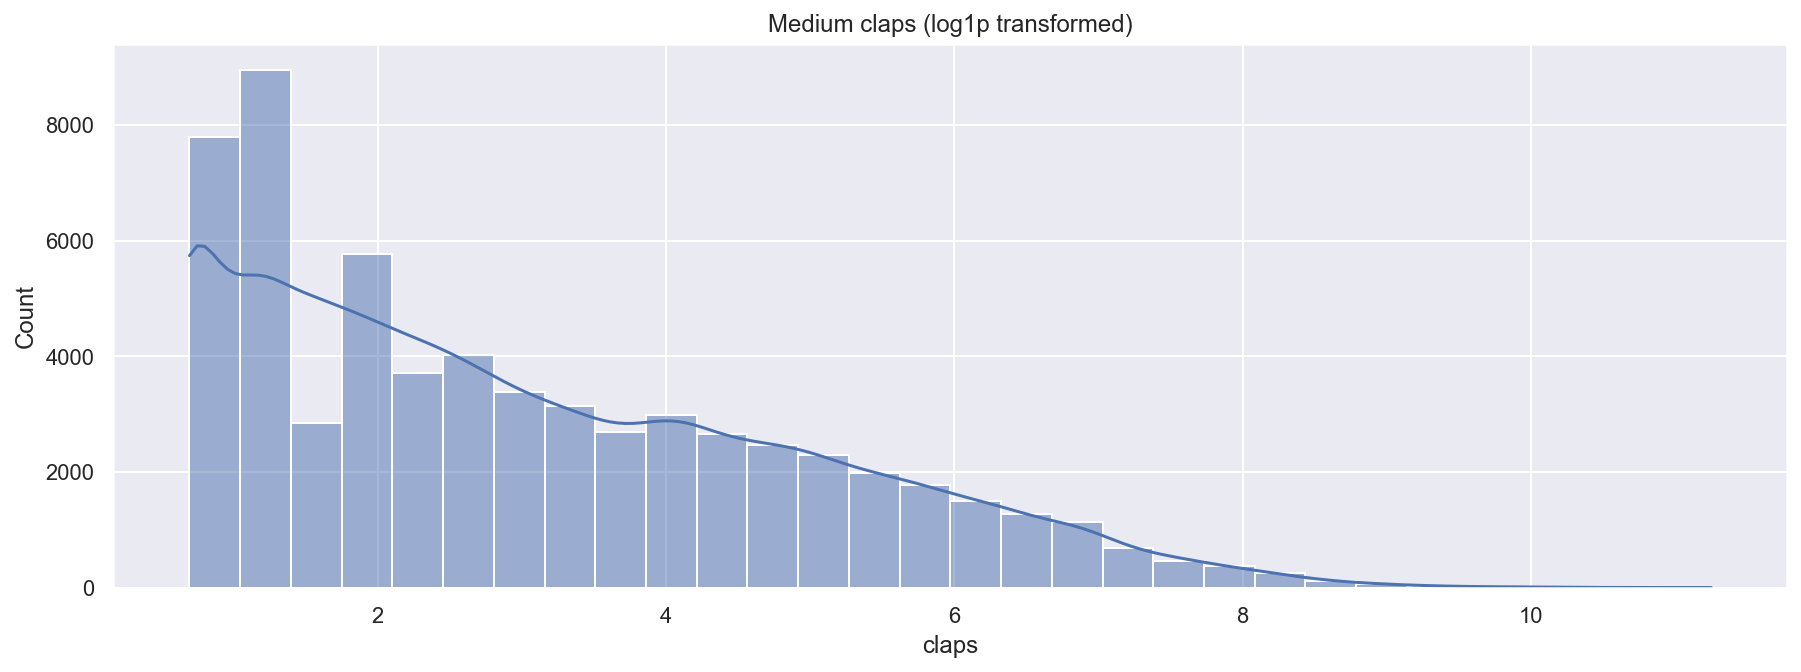

In [19]:
plt.figure(figsize=(15,5))
plt.title("Medium claps (log1p transformed)")
sns.histplot(train_df.claps, bins=30, kde=True);

The ditribution of claps in Medium is far from being normal. Even after log transformation.  
The data is skewed to the right, meaning there are lots of data clapped many thousands times.
Let's see some of them.

In [20]:
# set_option will display urls in full
pd.set_option('display.max_colwidth', None)
# first five most clapped articles
train_df.sort_values(by='claps', ascending=False)["url"].head()

41024    https://medium.com/personal-growth/13-things-you-need-to-give-up-if-you-want-to-be-successful-44b5b9b06a26
43838                                                   https://medium.com/@dinachka82/about-your-poem-1f26a7585a6f
9437                     https://entrepreneurs.maqtoob.com/the-37-best-websites-to-learn-something-new-895e2cb0cad4
33841                                  https://hackernoon.com/how-it-feels-to-learn-javascript-in-2016-d3a717dd577f
62221                                                     https://hackernoon.com/wtf-is-the-blockchain-1da89ba19348
Name: url, dtype: object

First 2 articles have 95k and 145k claps respectively. Such articles skew our data to the right.  
It means we will not be able to use parametric statistical tests.

In [21]:
# reset_option will fix the column width back to default
pd.reset_option('display.max_colwidth')

### reusable function for visualization

In [22]:
def two_count_plots(x1, x2, 
                    title1, title2, 
                    order1=None, order2=None,
                    sharey=False, rotation=0):
    
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=sharey, figsize=(16,6))

    sns.countplot(x=x1, ax=ax1, order=order1);
    sns.countplot(x=x2, ax=ax2, order=order2);

    ax1.set_title(title1);
    ax2.set_title(title2);
    
    if order1 is None: order1 = x1.value_counts().index
    if order2 is None: order2 = x2.value_counts().index
        
    ax1.set_xticklabels(labels=order1, rotation=rotation);
    ax2.set_xticklabels(labels=order2, rotation=rotation);
    
    
def box_and_bar_plots(x1, x2, 
                      y1, 
                      title1, title2, 
                      ylabel2, 
                      hue1=None, xticklabels=None):
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.boxplot(x=x1, y=y1, ax=ax1, hue=hue1);
    sns.barplot(x=x2.index, y=np.round(x2.values), ax=ax2)

    plt.ylabel(ylabel2)
    
    if xticklabels:
        ax1.set_xticklabels(xticklabels);
        ax2.set_xticklabels(xticklabels);
    ax1.set_title(title1);
    ax2.set_title(title2);

### time series features

In [23]:
# number of articles for each year
train_df.year.value_counts()

2016    25120
2017    20818
2015    11187
2014     3940
2013     1078
2012       96
2011       36
2010       10
2008        8
2009        8
1970        3
2007        3
2006        2
2003        1
2004        1
2005        1
1987        1
Name: year, dtype: int64

Until 2013 we have too few artcles. Let's observe starting from 2013

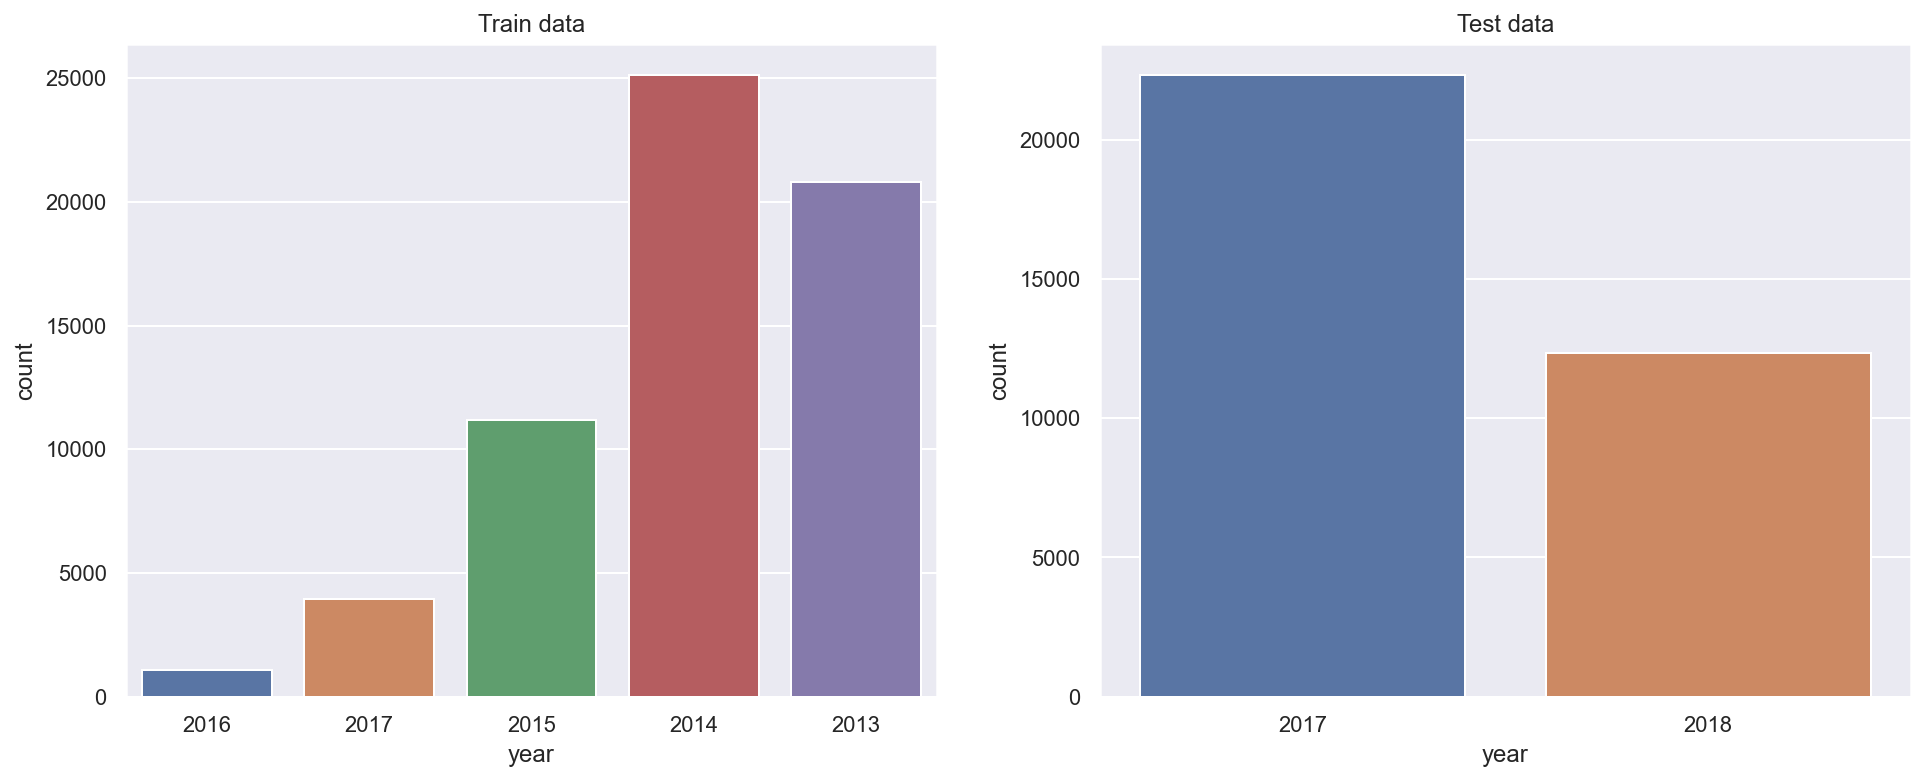

In [24]:
two_count_plots(x1 = train_df[train_df.year >= 2013].year,
                x2 = test_df.year,
                title1 = "Train data",
                title2 = "Test data")

The number of articles increases each year.  
2017 in train set has only half of the data, another half is in the test set.  
2018 has only few months.

In [25]:
# concatenating both sets to get better understanding of the data
train_target = train_df['claps'].copy()
full_df = pd.concat([train_df.drop('claps', axis=1), test_df]).copy()
# index to split train_df from test_df
idx_split = train_df.shape[0]

In [26]:
# checking the last month of observations
full_df[full_df.year == 2018].groupby("month").content.count()

month
1    5682
2    6479
3     167
Name: content, dtype: int64

March of 2018 has too few observations, will not use it.

In [27]:
# establishing time range from 2015 till February of 2018
time_range = (full_df.year >= 2015) & (full_df.published < pd.to_datetime('2018-03-01'))
count = pd.DatetimeIndex(full_df[time_range].published).to_period("M").value_counts()
count.sort_index(ascending=True, inplace=True)

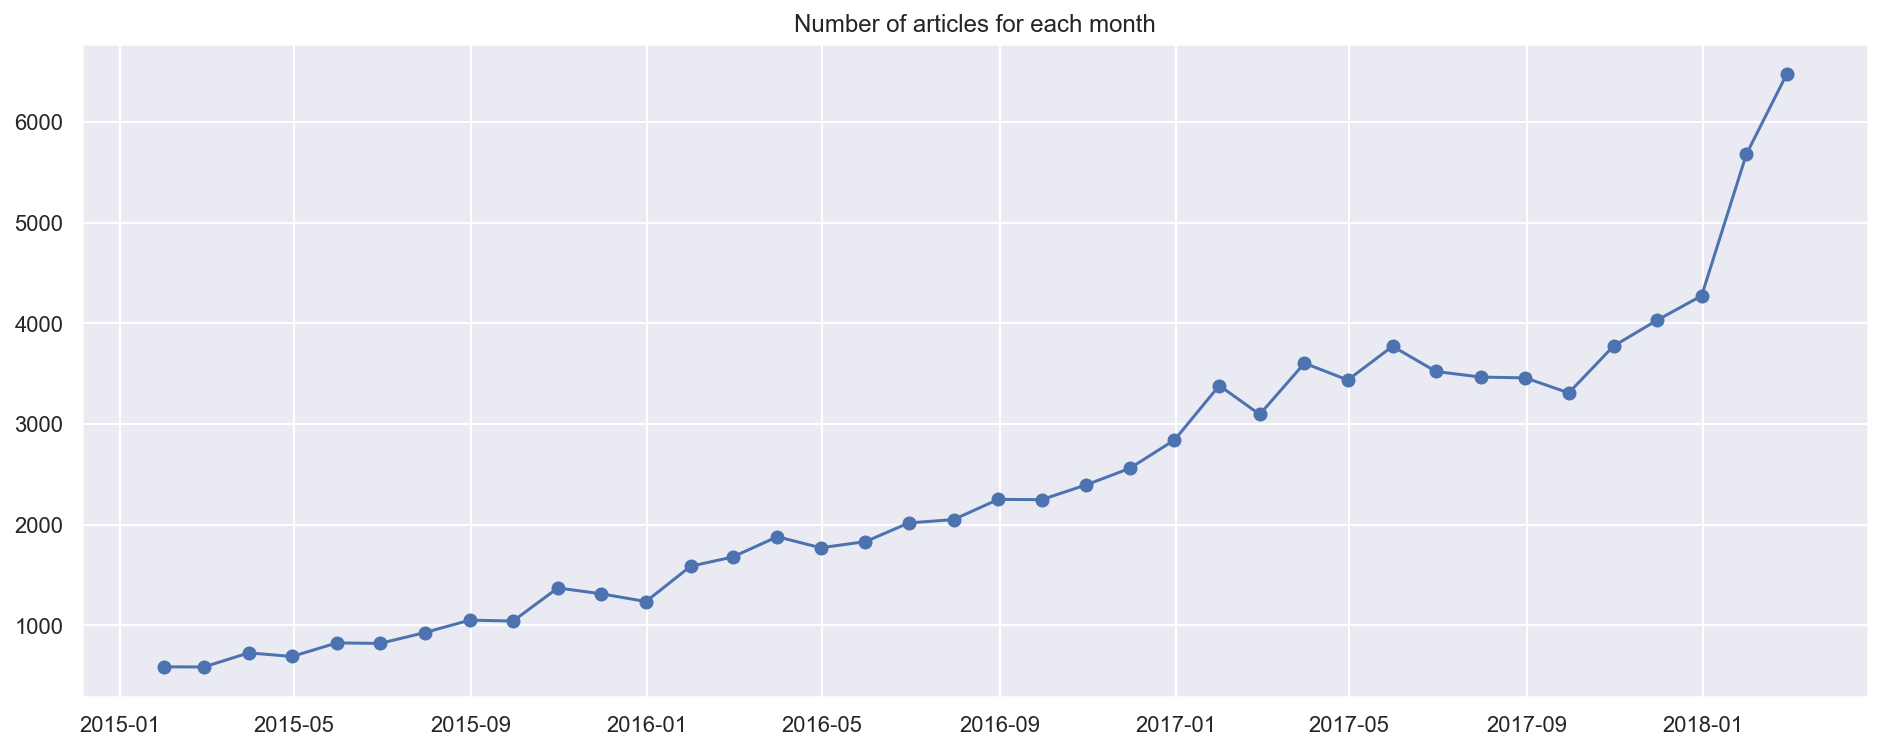

In [28]:
plt.figure(figsize = (16,6));
plt.title("Number of articles for each month")
plt.plot_date(count.index, count.values, label="A", linestyle="-");

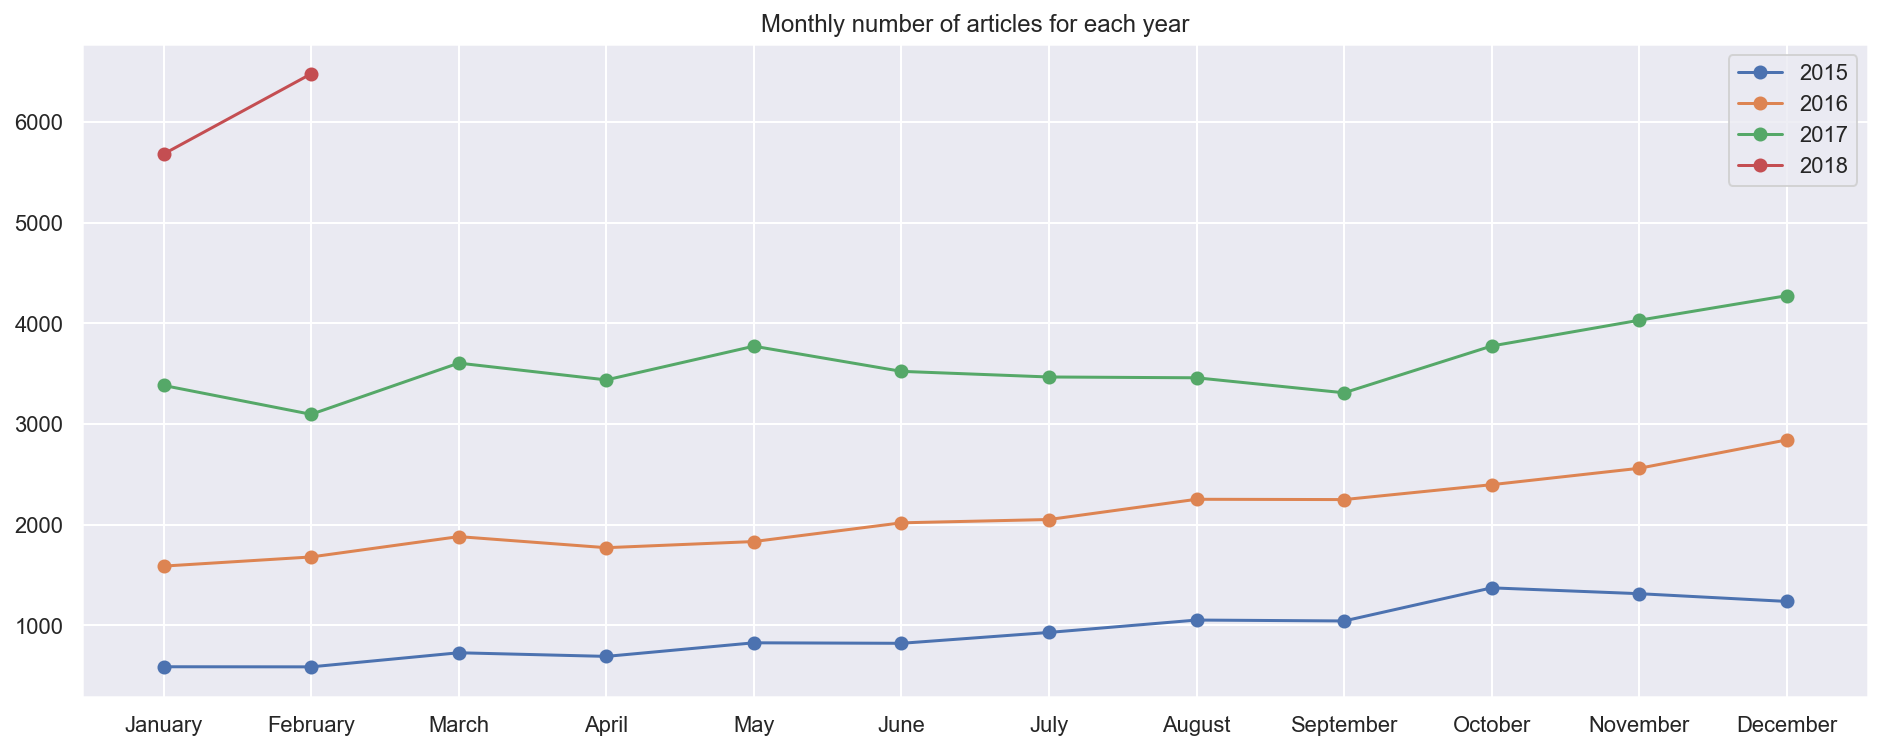

In [29]:
time_range_2018 = (full_df.year == 2018) & (full_df.published < pd.to_datetime('2018-03-01'))
fig, ax = plt.subplots(1,1, figsize = (16,6));
labels = ["January","February","March","April","May","June",
          "July","August","September","October","November","December"]

for year in range(2015, 2019):
    if year == 2018:
        count = full_df[time_range_2018].groupby("month").content.count()
        ax.plot(range(1,3), count.values, label=year, marker="o");
    else:
        count = full_df[full_df.year == year].groupby("month").content.count()
        ax.plot(range(1,13), count.values, label=year, marker="o");
        
ax.set_xticks(range(1,13))
ax.set_xticklabels(labels)
plt.title("Monthly number of articles for each year")
plt.legend();

April and September have less published articles in 2015-2017.  
In March, May and October it's opposite situation.  
In 2018 an increase in popularity is observed.

In [198]:
count = train_df[train_df.year >= 2015].groupby(["year","month"]).claps.sum()

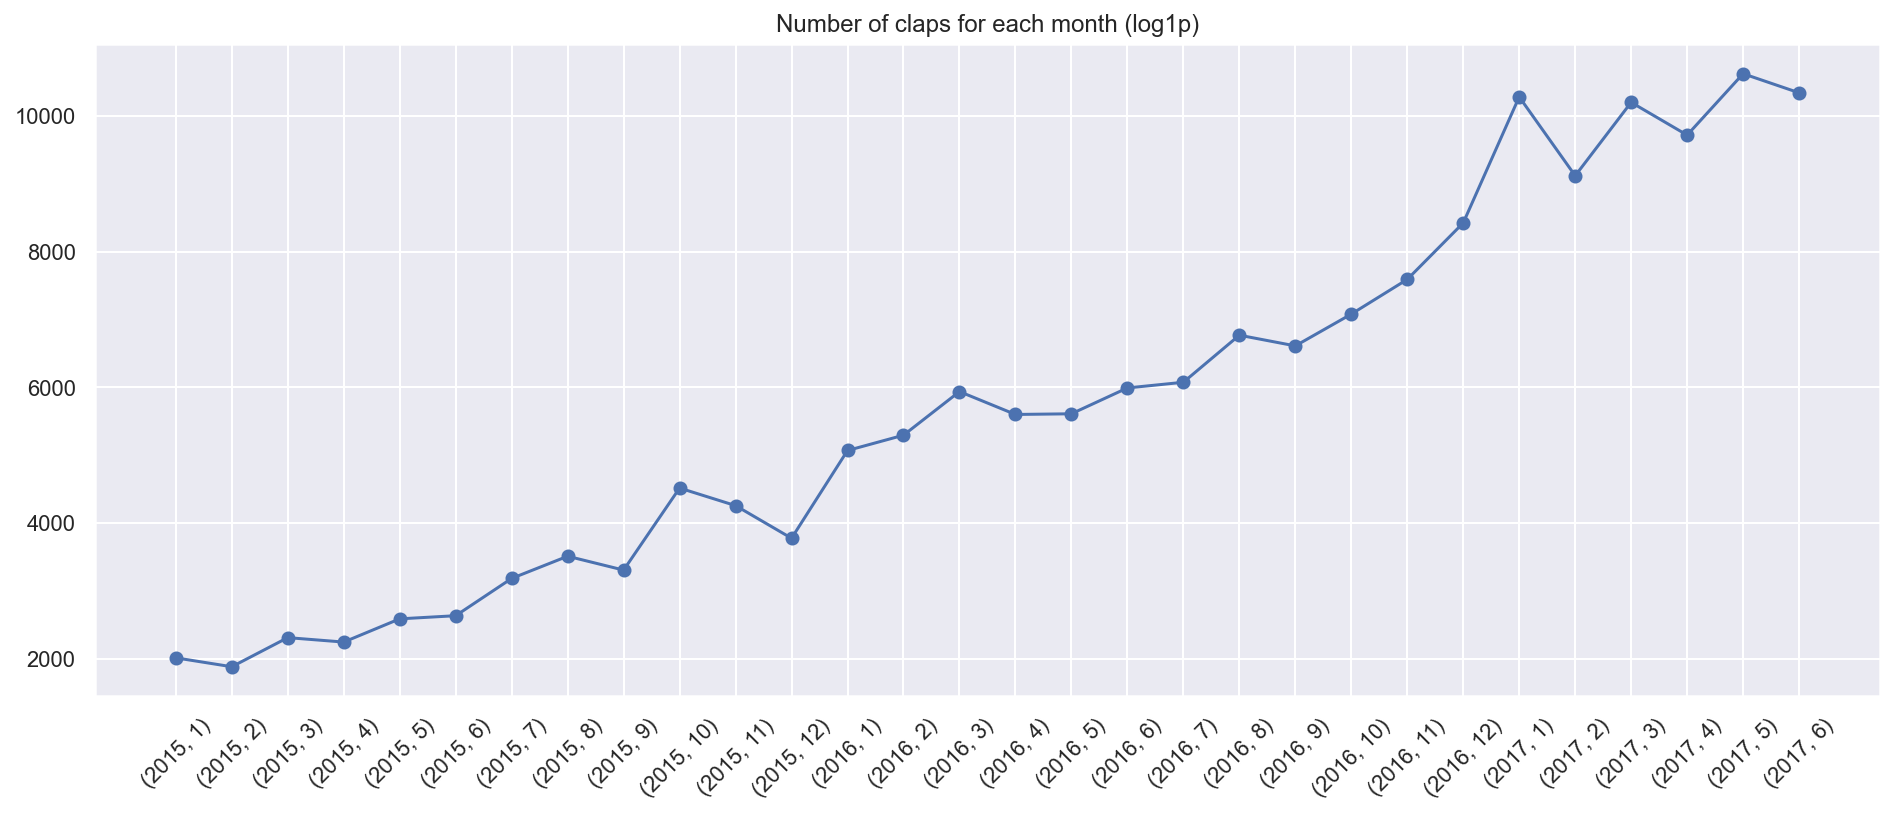

In [201]:
fig, ax = plt.subplots(1,1, figsize = (16,6));
plt.title("Number of claps for each month (log1p)")
ax.plot(range(len(count.index)), count.values, marker="o");
ax.set_xticks(range(len(count.index)))
ax.set_xticklabels(count.index, rotation=45);

Number of claps growth with rate closely to the number of articles.

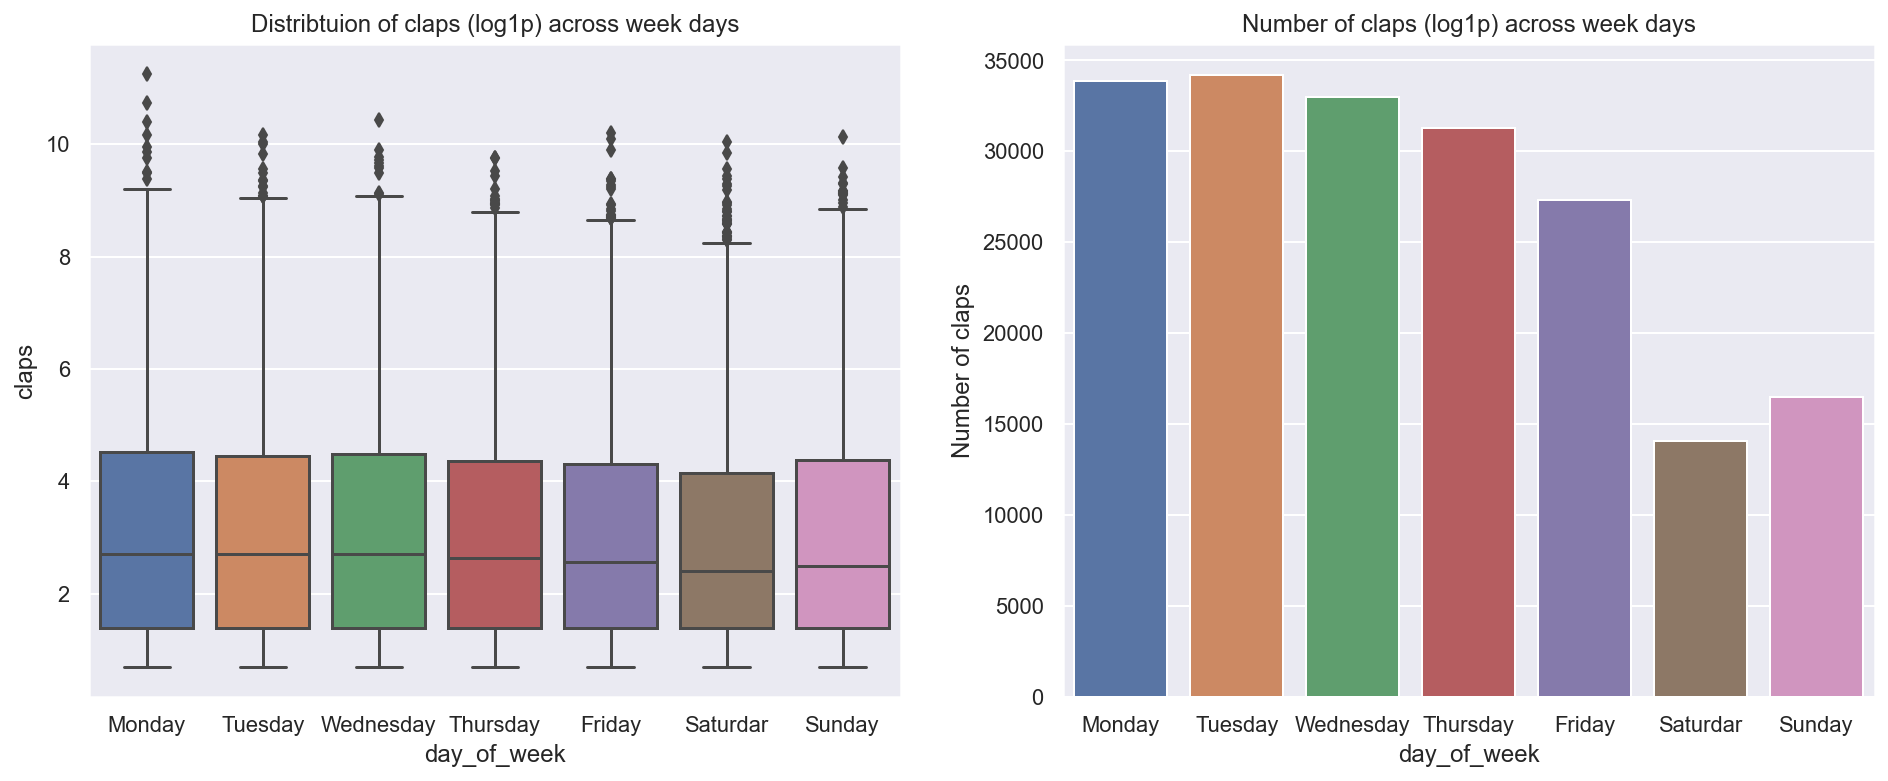

In [273]:
week_days = ['Monday', 'Tuesday', 'Wednesday', 
             'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_claps = train_df.groupby('day_of_week')['claps'].sum()

box_and_bar_plots(x1 = train_df.day_of_week, x2 = dow_claps, 
                  y1 = train_df.claps,
                  title1 = "Distribtuion of claps (log1p) across week days", 
                  title2 = "Number of claps (log1p) across week days", 
                  ylabel2 = "Number of claps",
                  xticklabels = week_days)

Median number of claps is a bit higer in the beginning of the week, but the difference is insignificant.  
Number of claps is significantly more in the beginning of the week.  
It's directly proportional to working days of week.

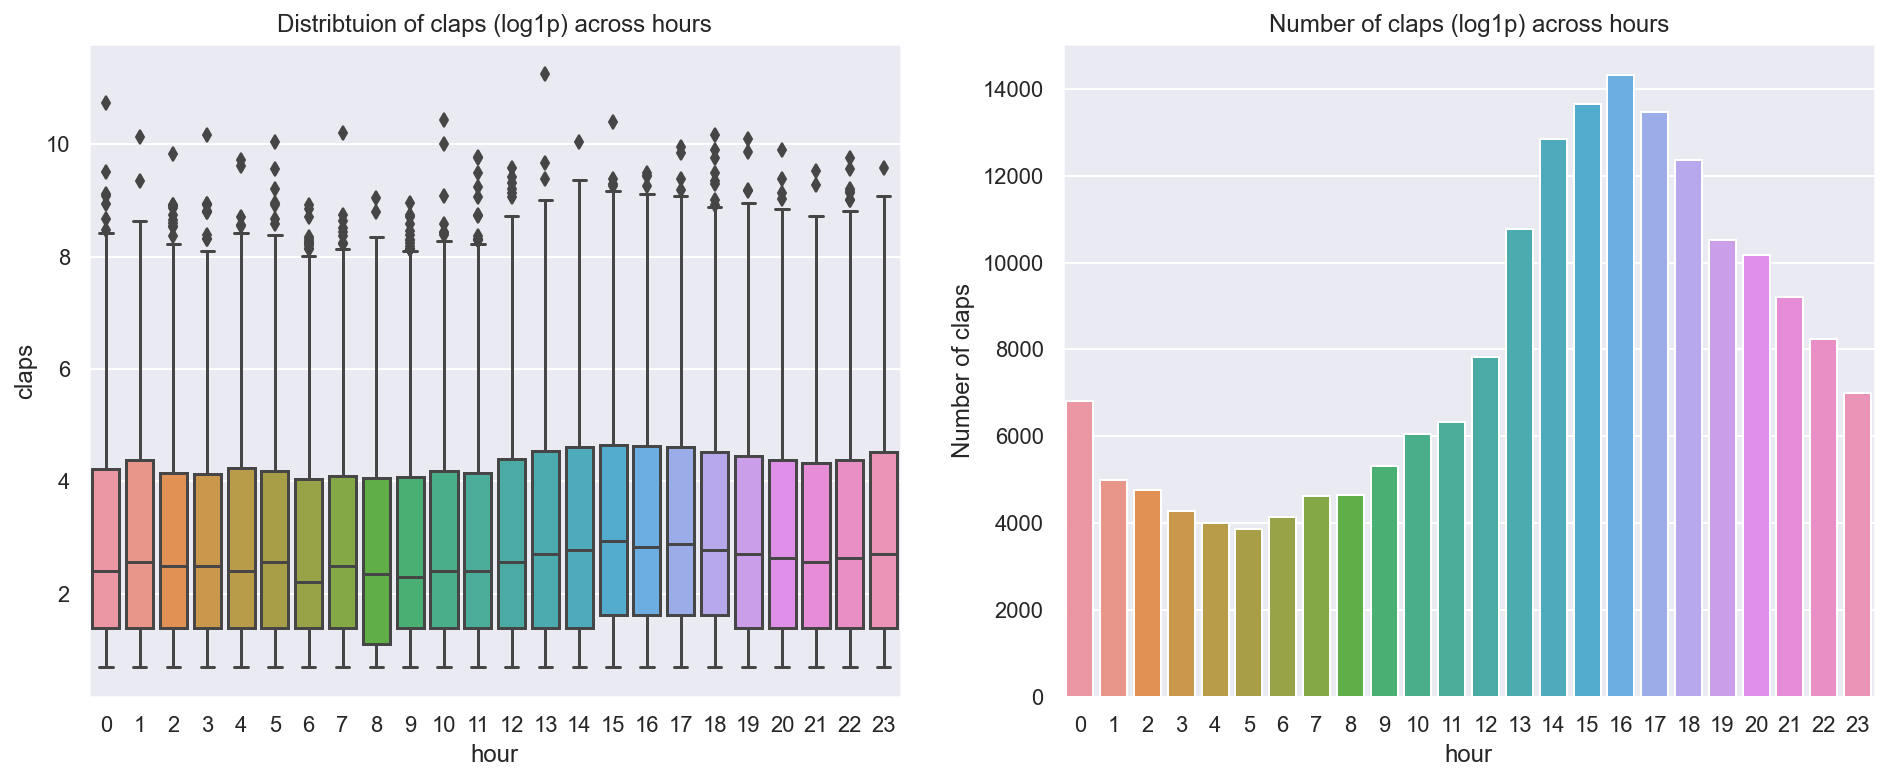

In [272]:
hour_claps = train_df.groupby('hour')['claps'].sum()

box_and_bar_plots(x1 = train_df.hour, x2 = hour_claps, 
                  y1 = train_df.claps,
                  title1 = "Distribtuion of claps (log1p) across hours", 
                  title2 = "Number of claps (log1p) across hours", 
                  ylabel2 = "Number of claps")

Highest median number of claps is afteernoon.  
Highest number of claps is afternoon.

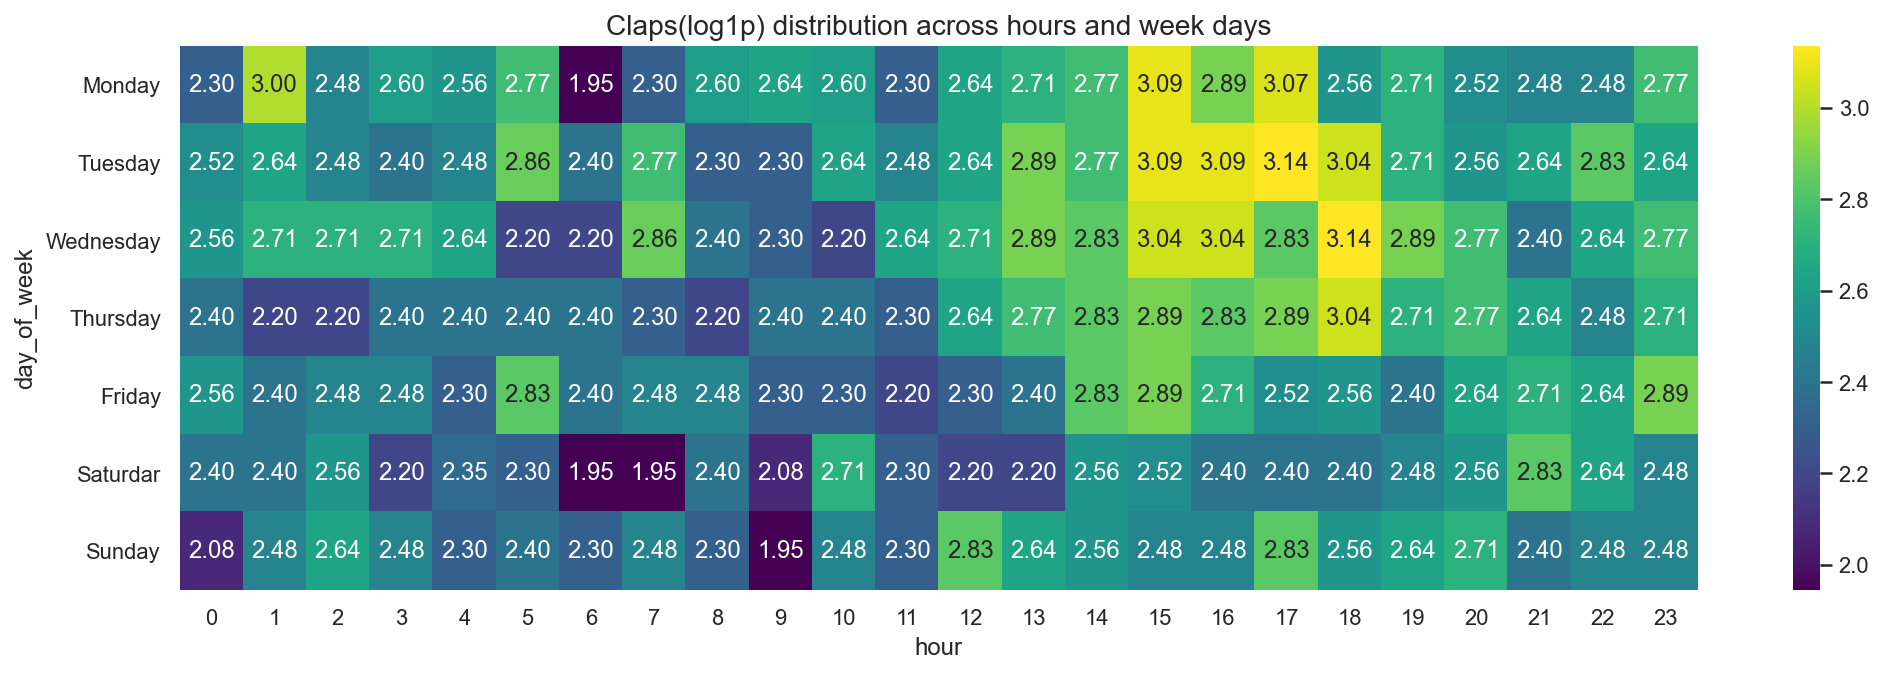

In [34]:
plt.figure(figsize=(17,5))
temp = train_df.pivot_table(index='day_of_week', columns='hour', 
                            values='claps', aggfunc='median')

ax = sns.heatmap(temp, annot=True, fmt='.2f', cmap='viridis')
ax.set_title('Claps(log1p) distribution across hours and week days', fontsize=14)

ax.set_yticklabels(week_days, rotation=0);

Highest median number of claps are around Monday-Thursday and 14:00-18:00.  
Also there are exceptions: 
- Monday: at 1:00,
- Tuesday and Friday: early morning at 5:00,
- Wednesday: morning at 7:00, 
- Friday and Saturday: late evening at 23:00 and 21:00 respectively,
- Sunday: noon at 12:00 and afternoon at 17:00.

### domain features

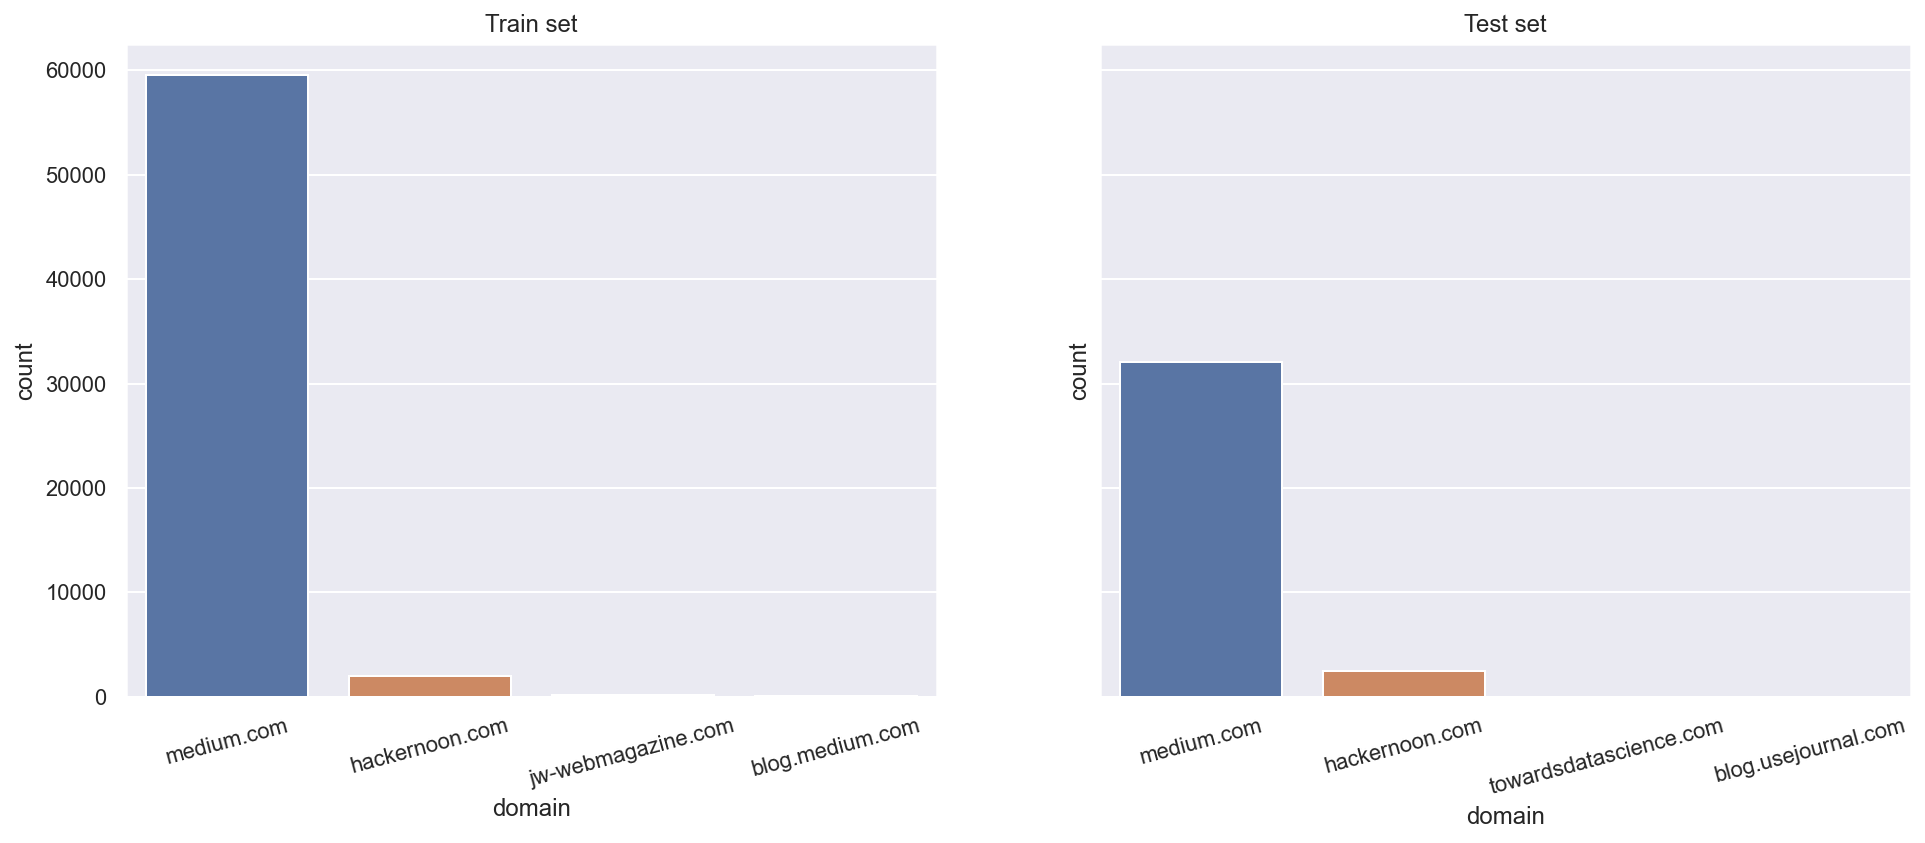

In [35]:
two_count_plots(x1 = train_df.domain, x2 = test_df.domain,
                title1 = "Train set", title2 = "Test set",
                order1 = train_df.domain.value_counts().iloc[:4].index,
                order2 = test_df.domain.value_counts().iloc[:4].index,
                sharey=True, rotation=15)

Domains of *medium.com* and *hackernoon.com* can only be considered.

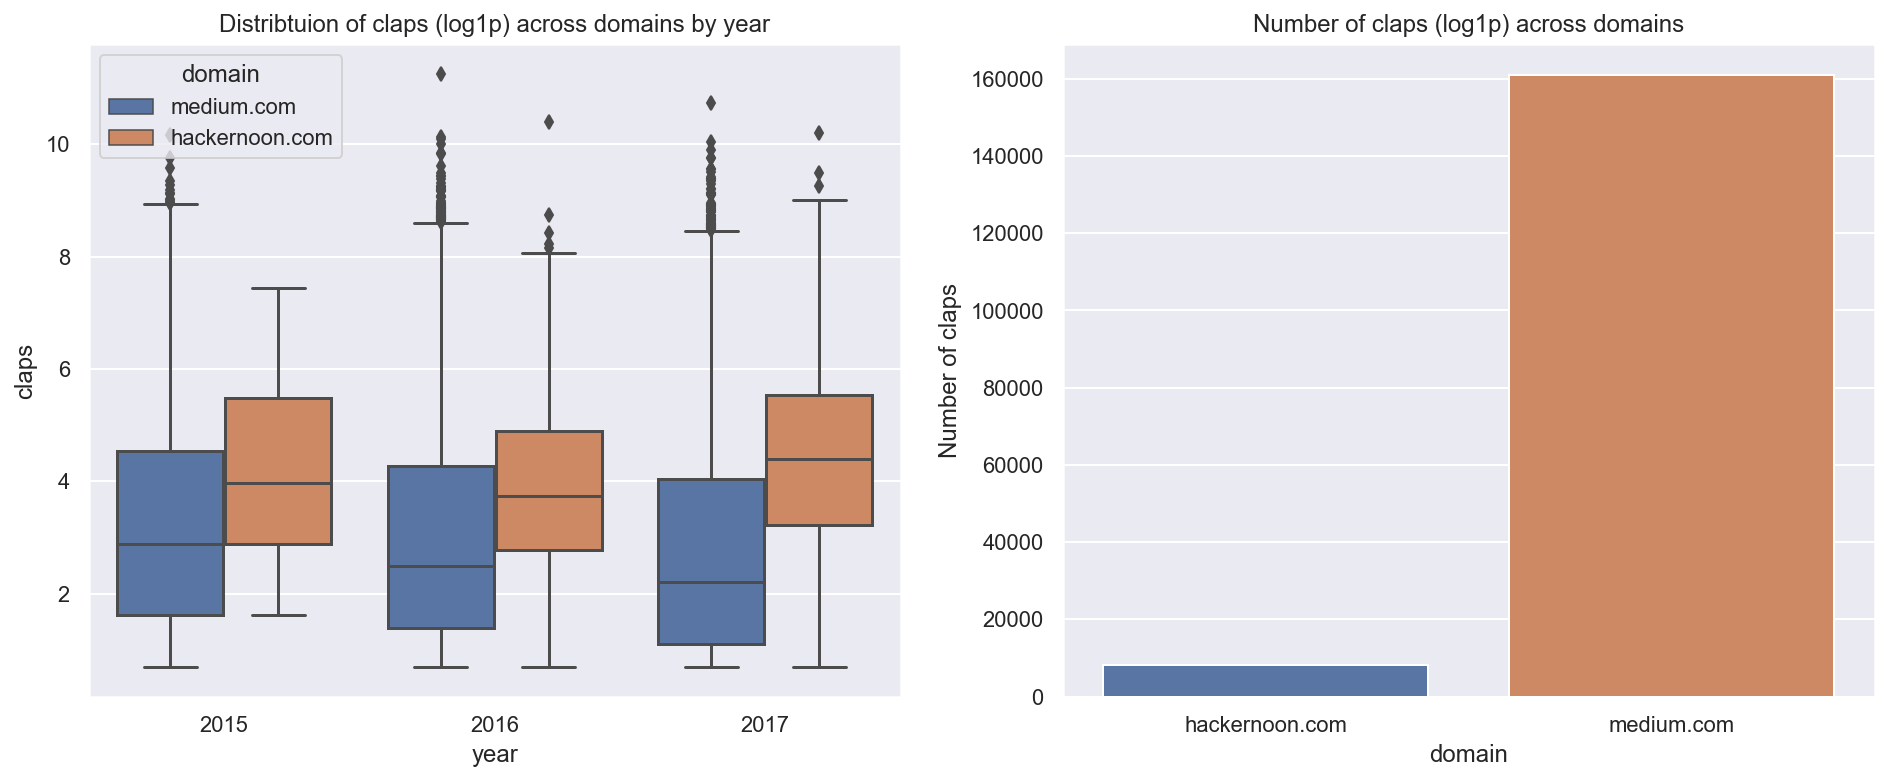

In [36]:
med_hack = train_df.domain.isin(['medium.com', 'hackernoon.com'])
# train_df domain is medium.com or hackernoon.com
train_df_temp = train_df[med_hack & (train_df.year >= 2015)]
domain_claps = train_df_temp.groupby("domain")["claps"].sum()

box_and_bar_plots(x1 = train_df_temp.year, x2 = domain_claps, 
                  y1 = train_df_temp.claps, hue1 = train_df_temp.domain,
                  title1 = "Distribtuion of claps (log1p) across domains by year", 
                  title2 = "Number of claps (log1p) across domains", 
                  ylabel2 = "Number of claps")

Median number of claps on *medium.com* decreases year by year.  
Median number of claps on *hackernoon.com* is always higher and remains at the same level.  
But most of the articles are still being published on *medium.com*.

### author features

/Users/nulyaka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nulyaka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0, flags=flags)


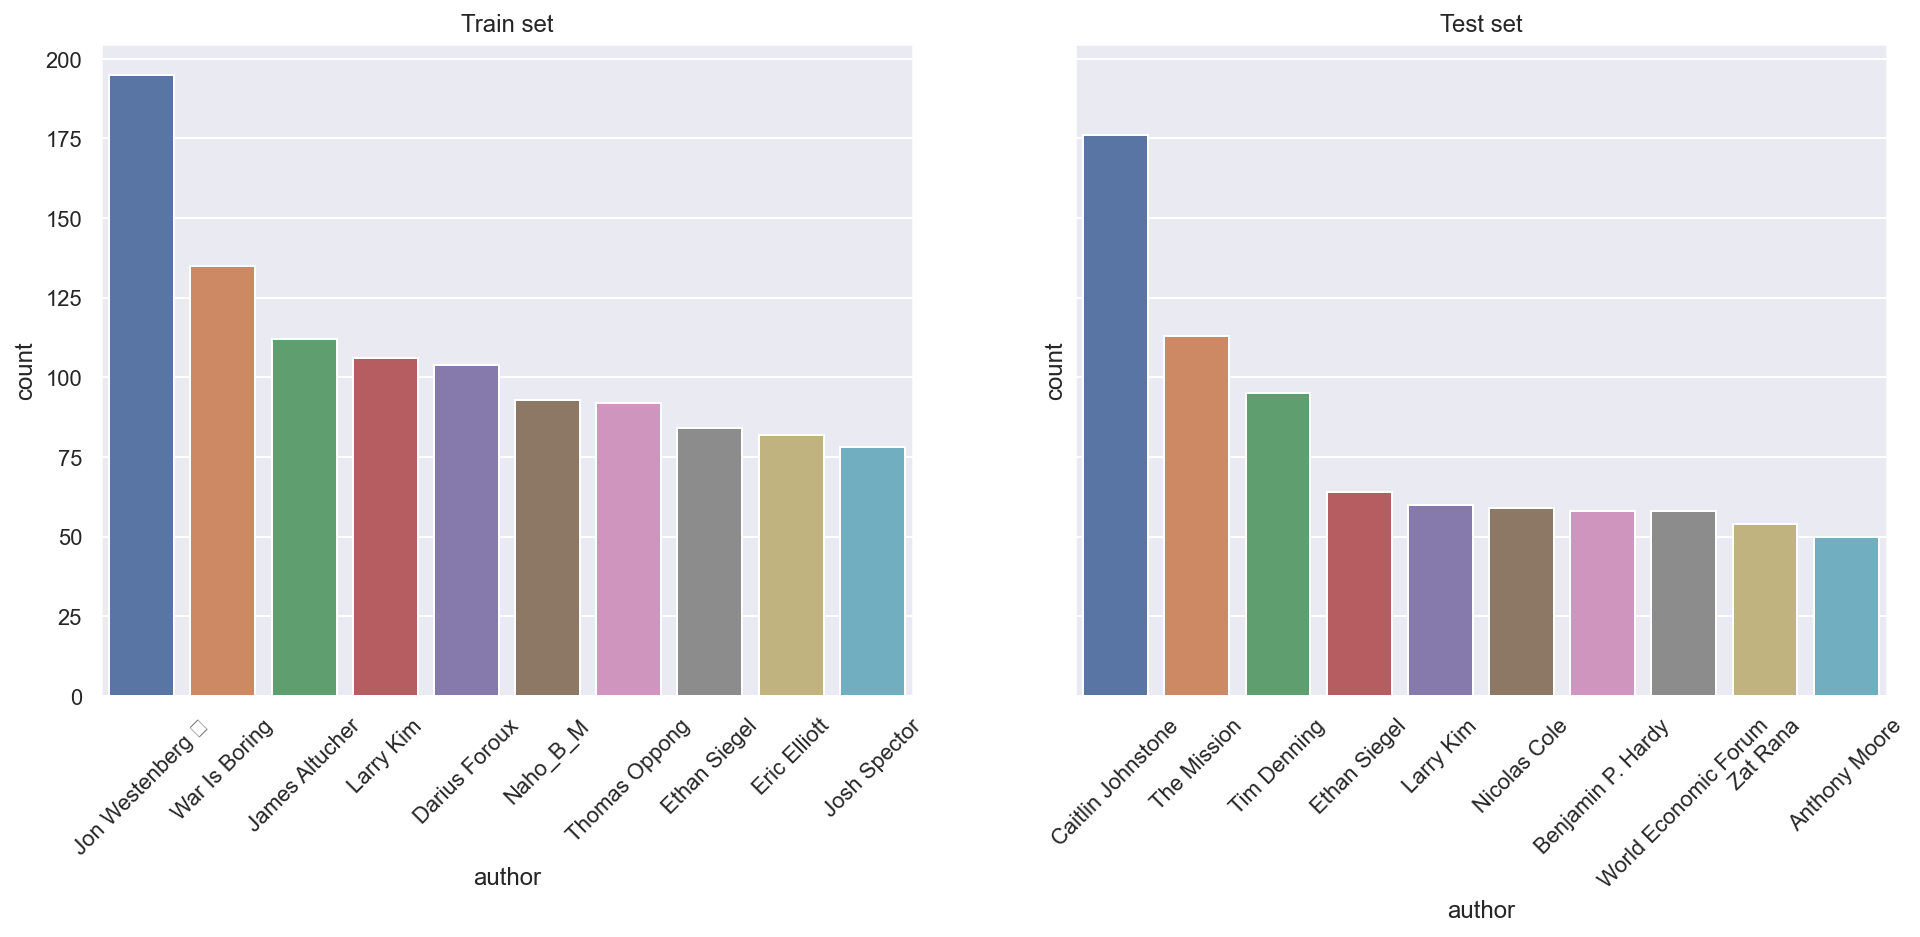

In [37]:
two_count_plots(x1 = train_df[train_df.year >= 2015].author, x2 = test_df.author,
                title1 = "Train set", title2 = "Test set",
                order1 = train_df[train_df.year >= 2015].author.value_counts().iloc[:10].index,
                order2 = test_df.author.value_counts().iloc[:10].index,
                sharey=True, rotation=45)

There are new active authors in the test set.  
It's explainable as both sets are with different time intervals.  
Some of them remain active. E.g. Larry Kim.

In [38]:
# reusable function
def top30_authors(count, title):
    count = count.sort_values(ascending=False)[:30]
    plt.figure(figsize = (16,6))
    plt.title(title)
    sns.barplot(x=count.index, y=np.round(count.values, 1))
    plt.xticks(rotation=90);

/Users/nulyaka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nulyaka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0, flags=flags)


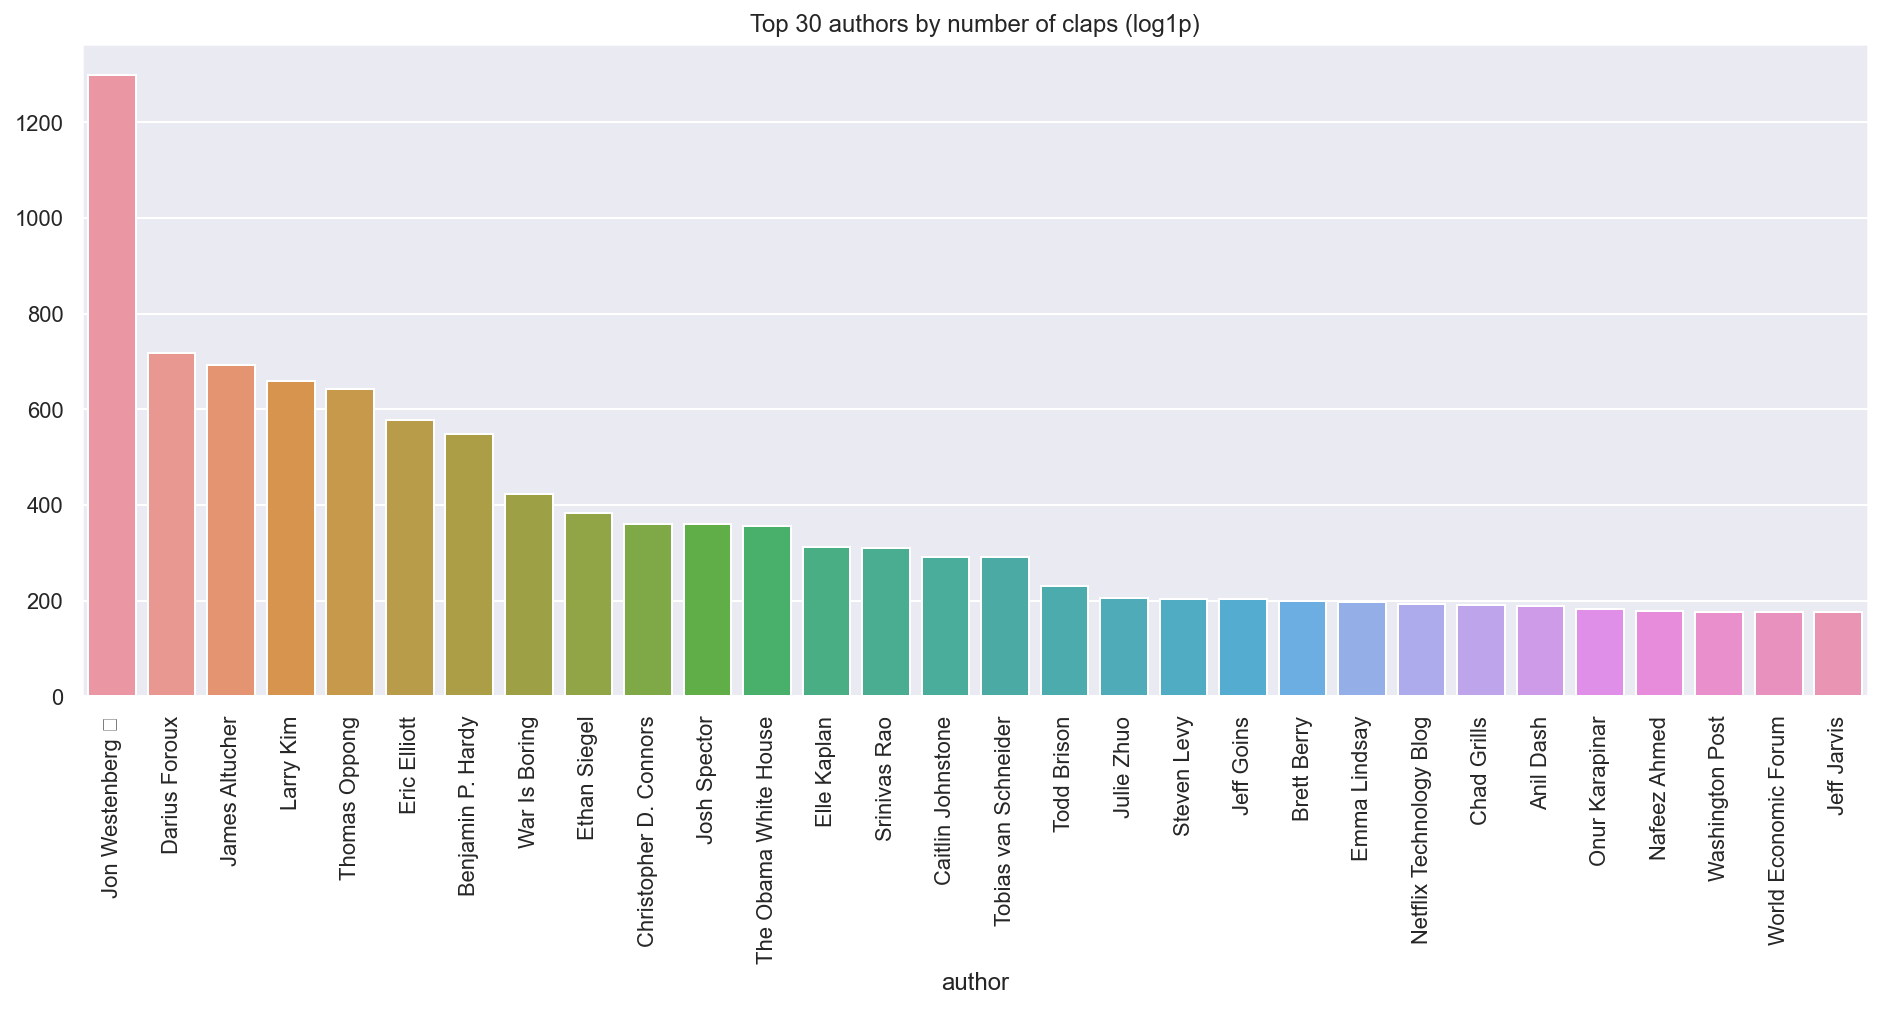

In [39]:
count = train_df[train_df.year >= 2015].groupby("author").claps.sum()
top30_authors(count, title="Top 30 authors by number of claps (log1p)")

In [40]:
# grouping by authors
authors = train_df[train_df.year >= 2015].groupby("author").count()
# authors with 10 articles or more
authors_w10a = authors[authors.content > 10].index
# median claps for each author
authors_w10a_median = train_df[train_df.author.isin(authors_w10a)].groupby("author").claps.median()

/Users/nulyaka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nulyaka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0, flags=flags)


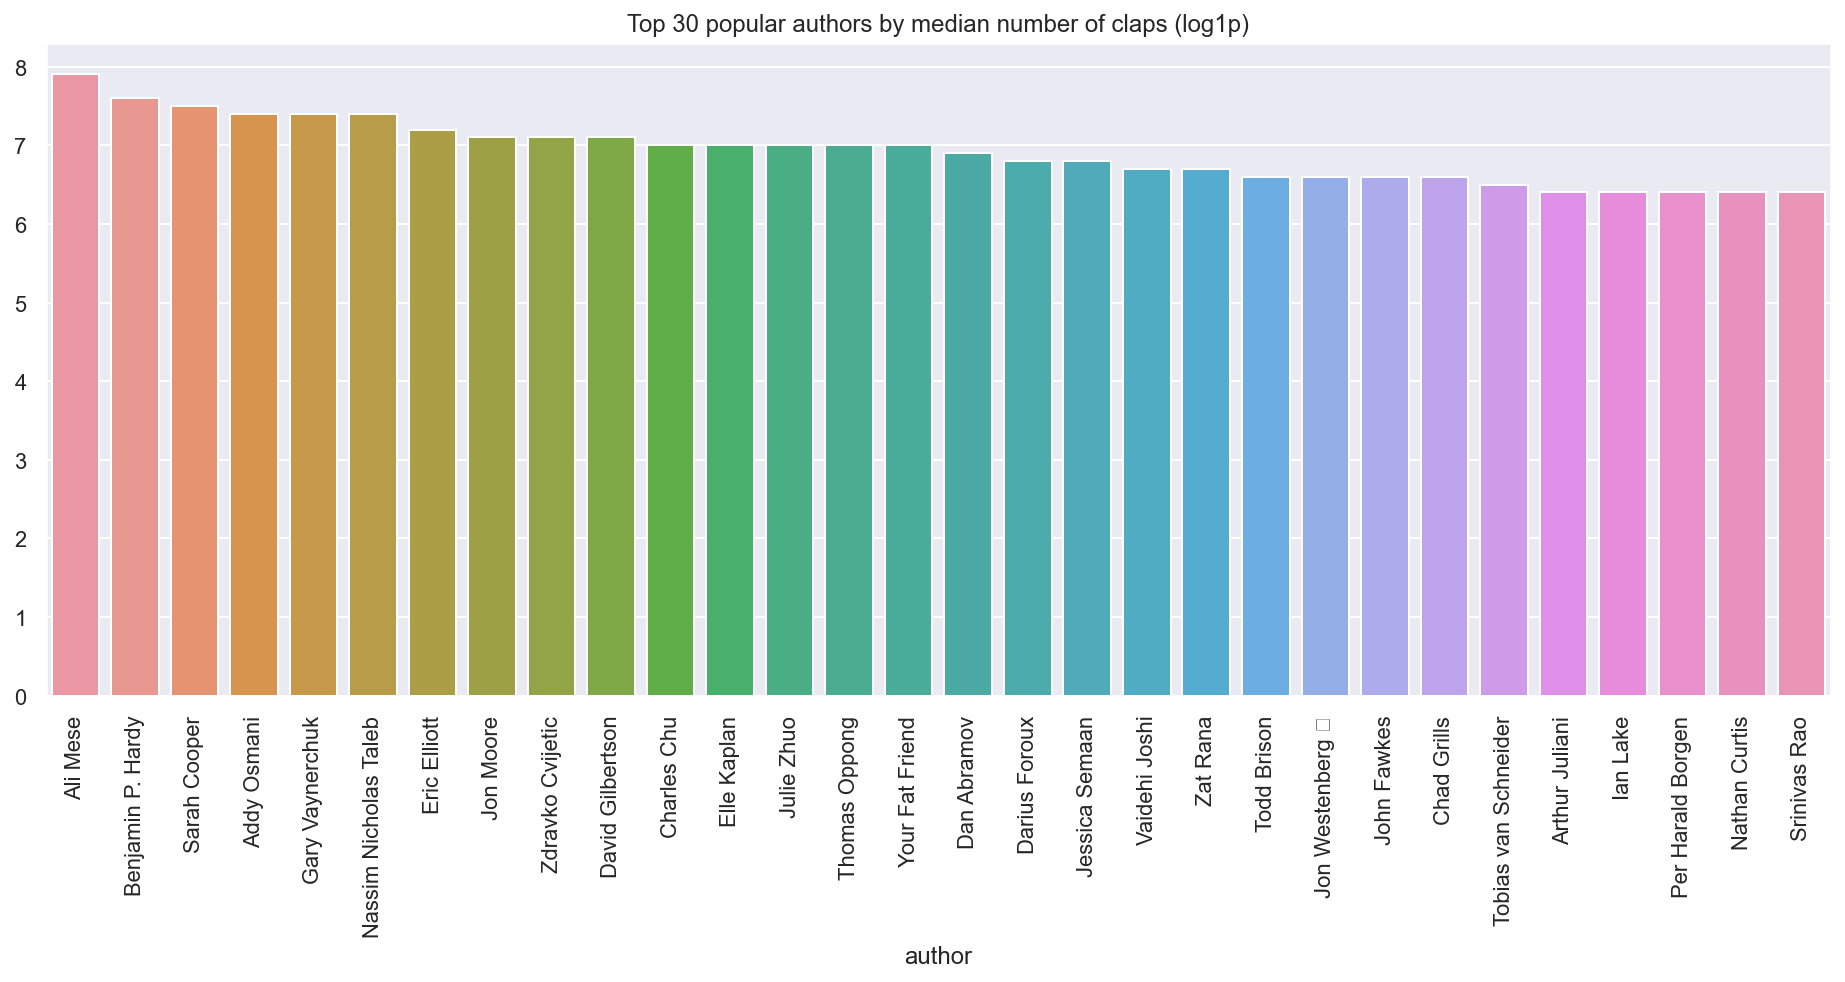

In [41]:
top30_authors(authors_w10a_median, 
              title="Top 30 popular authors by median number of claps (log1p)")

Let's check what top 5 authors write about.

In [42]:
top5_authors = authors_w10a_median.sort_values(ascending=False)[:5].index

In [43]:
train_df[(train_df.year >= 2015) & (train_df.author.isin(top5_authors))].tags[:5]

5700    Tech Startup Entrepreneurship Marketing Business
6091    Startup Tech Entrepreneurship Business Marketing
6594      Startup Tech Entrepreneurship Blogging Writing
7741                          Humor SanFrancisco NewYork
9232        Tech Startup Entrepreneurship Medium Blogger
Name: tags, dtype: object

In [44]:
train_df[(train_df.year >= 2015) & (train_df.author.isin(top5_authors))].tags[-5:]

61537    Life LifeLessons SelfImprovement Parenting Edu...
61686    SelfImprovement Life LifeLessons Startup Produ...
61825               Internships Tech Startup Business Life
61834               Life LifeLessons Business Startup Tech
62172    Entrepreneurship Startup Life LifeLessons Busi...
Name: tags, dtype: object

Top authors popular topics: 
- Start ups, Business, Marketing
- Life lessons, Self improvement
- Coding, programming, technologies

### content length features

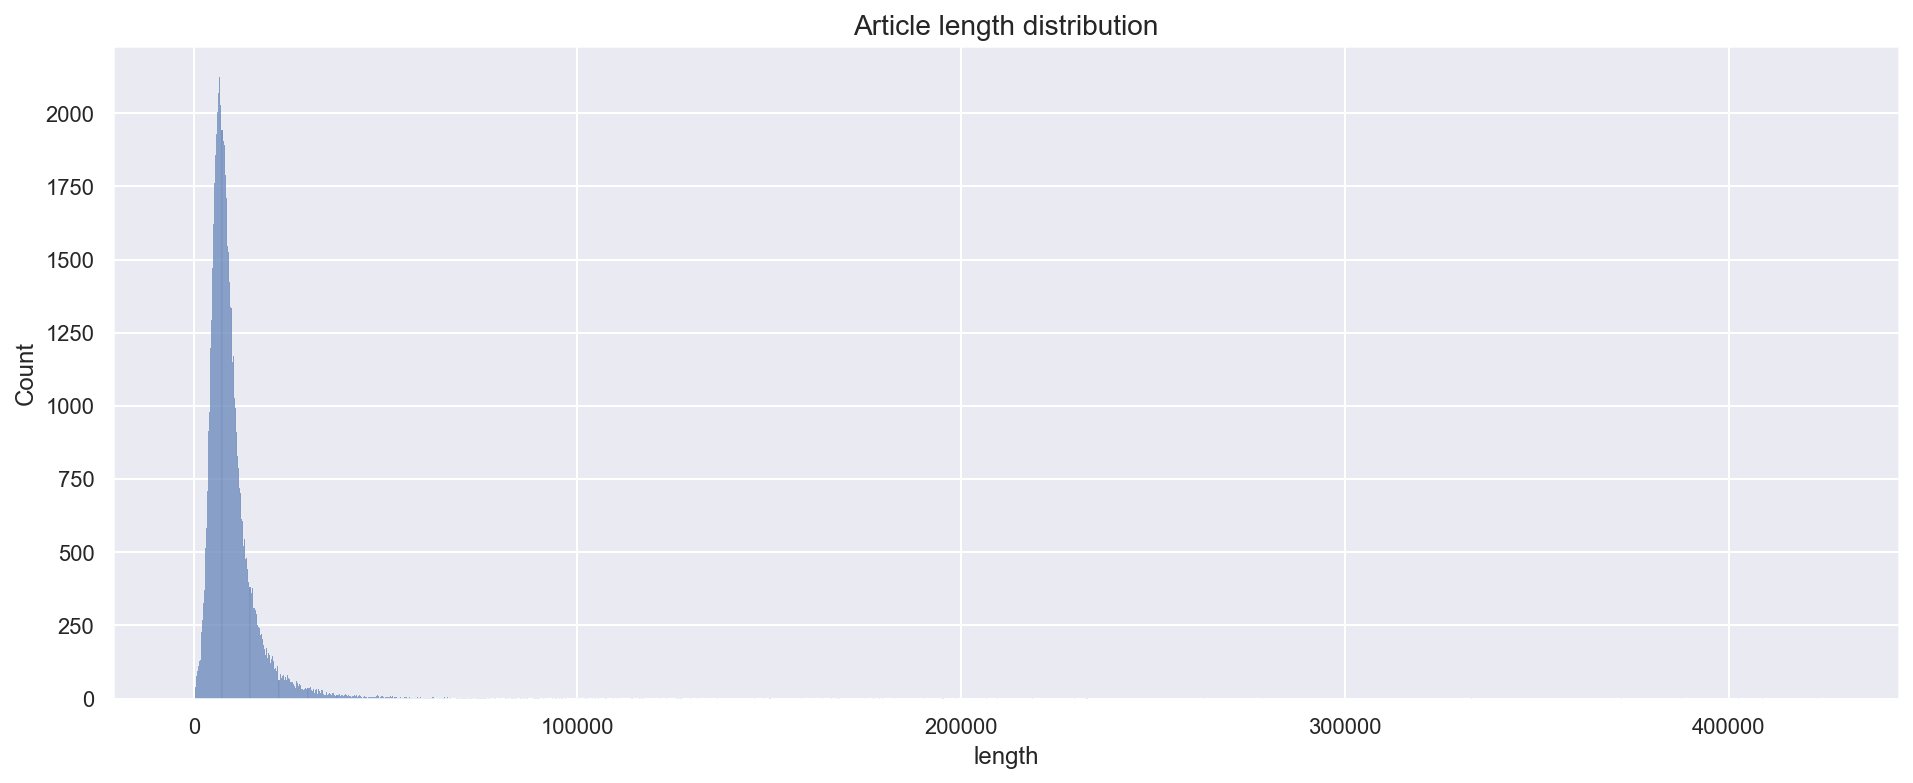

In [45]:
plt.figure(figsize=(16,6))
sns.histplot(train_df.length);
plt.title("Article length distribution", fontsize=14);

Some of the articles skew distribution to the right by having 400,000 characters.

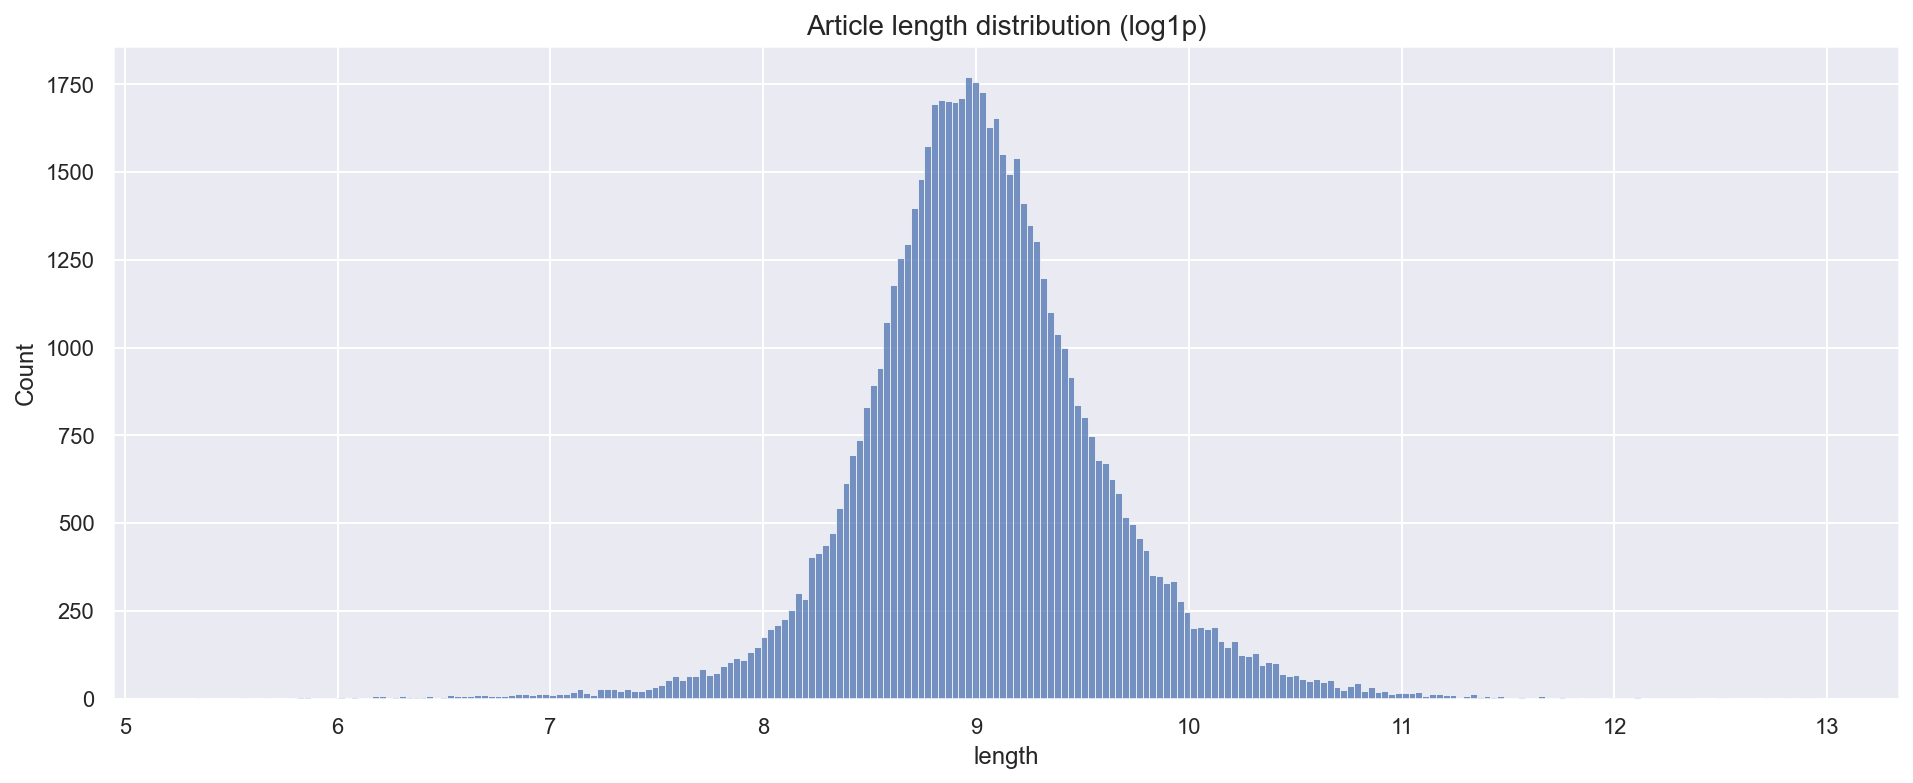

In [46]:
plt.figure(figsize=(16,6))
sns.histplot(np.log1p(train_df.length));
plt.title("Article length distribution (log1p)", fontsize=14);

CPU times: user 44.4 s, sys: 393 ms, total: 44.8 s
Wall time: 45.9 s


Text(0, 0.5, 'Number of claps (log1p)')

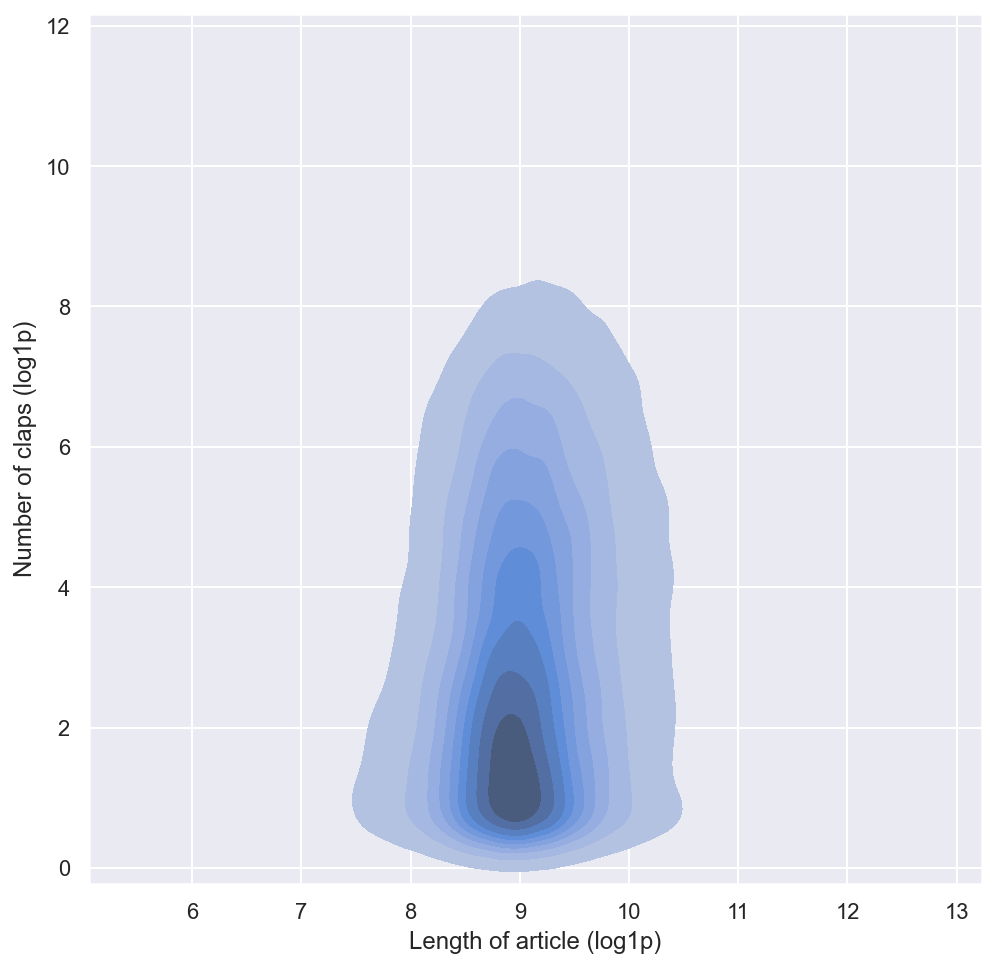

In [47]:
%%time
plt.figure(figsize=(8,8));
ax = sns.kdeplot(x=np.log1p(train_df.length), y=train_df.claps, shade=True, thresh=0.05);
ax.set_xlabel("Length of article (log1p)");
ax.set_ylabel("Number of claps (log1p)");

No correlation between article length and number of claps.

### tag features

In [248]:
def get_tags_df(df, is_train_df=False):
    # counting single tags
    vec = CountVectorizer(ngram_range=(1, 1), min_df=5)
    # tags frequency matrix 
    matrix = vec.fit_transform(df.tags.values).toarray()
    
    tags_df = pd.DataFrame()
    tags_df['tag'] = vec.get_feature_names()
    tags_df['number_of_posts'] = matrix.sum(axis=0).ravel()
    
    if is_train_df:
        # tags frequency matrix + claps
        matrix_claps = pd.DataFrame(matrix)
        matrix_claps['claps'] = df.claps.values 
        for col in range(matrix_claps.shape[1] - 1):
            sub_df = matrix_claps[matrix_claps[col] == 1]
            tags_df.loc[col, 'claps_median'] = sub_df.claps.median()
            tags_df.loc[col, 'claps_sum'] = sub_df.claps.sum()
        
    tags_df['tag'] = tags_df['tag'].astype(str)
    tags_df['number_of_posts'] = tags_df['number_of_posts'].astype(int)
    
    return tags_df

In [249]:
%%time
train_tags_df = get_tags_df(train_df[train_df.year >= 2015], is_train_df=True)

CPU times: user 22.5 s, sys: 3.03 s, total: 25.5 s
Wall time: 19.8 s


In [250]:
test_tags_df = get_tags_df(test_df)

In [251]:
train_tags_df.head()

,tag,number_of_posts,claps_median,claps_sum
0,13reasonswhy,17,2.20,38.90
1,1960s,6,1.24,7.45
2,1980s,8,4.37,31.78
3,1mdb,7,2.20,17.05
4,2015,24,2.09,66.10


In [252]:
top15_train_tags = train_tags_df.sort_values("number_of_posts", ascending=False).iloc[:15, :2]
top15_test_tags = test_tags_df.sort_values("number_of_posts", ascending=False).iloc[:15, :2]

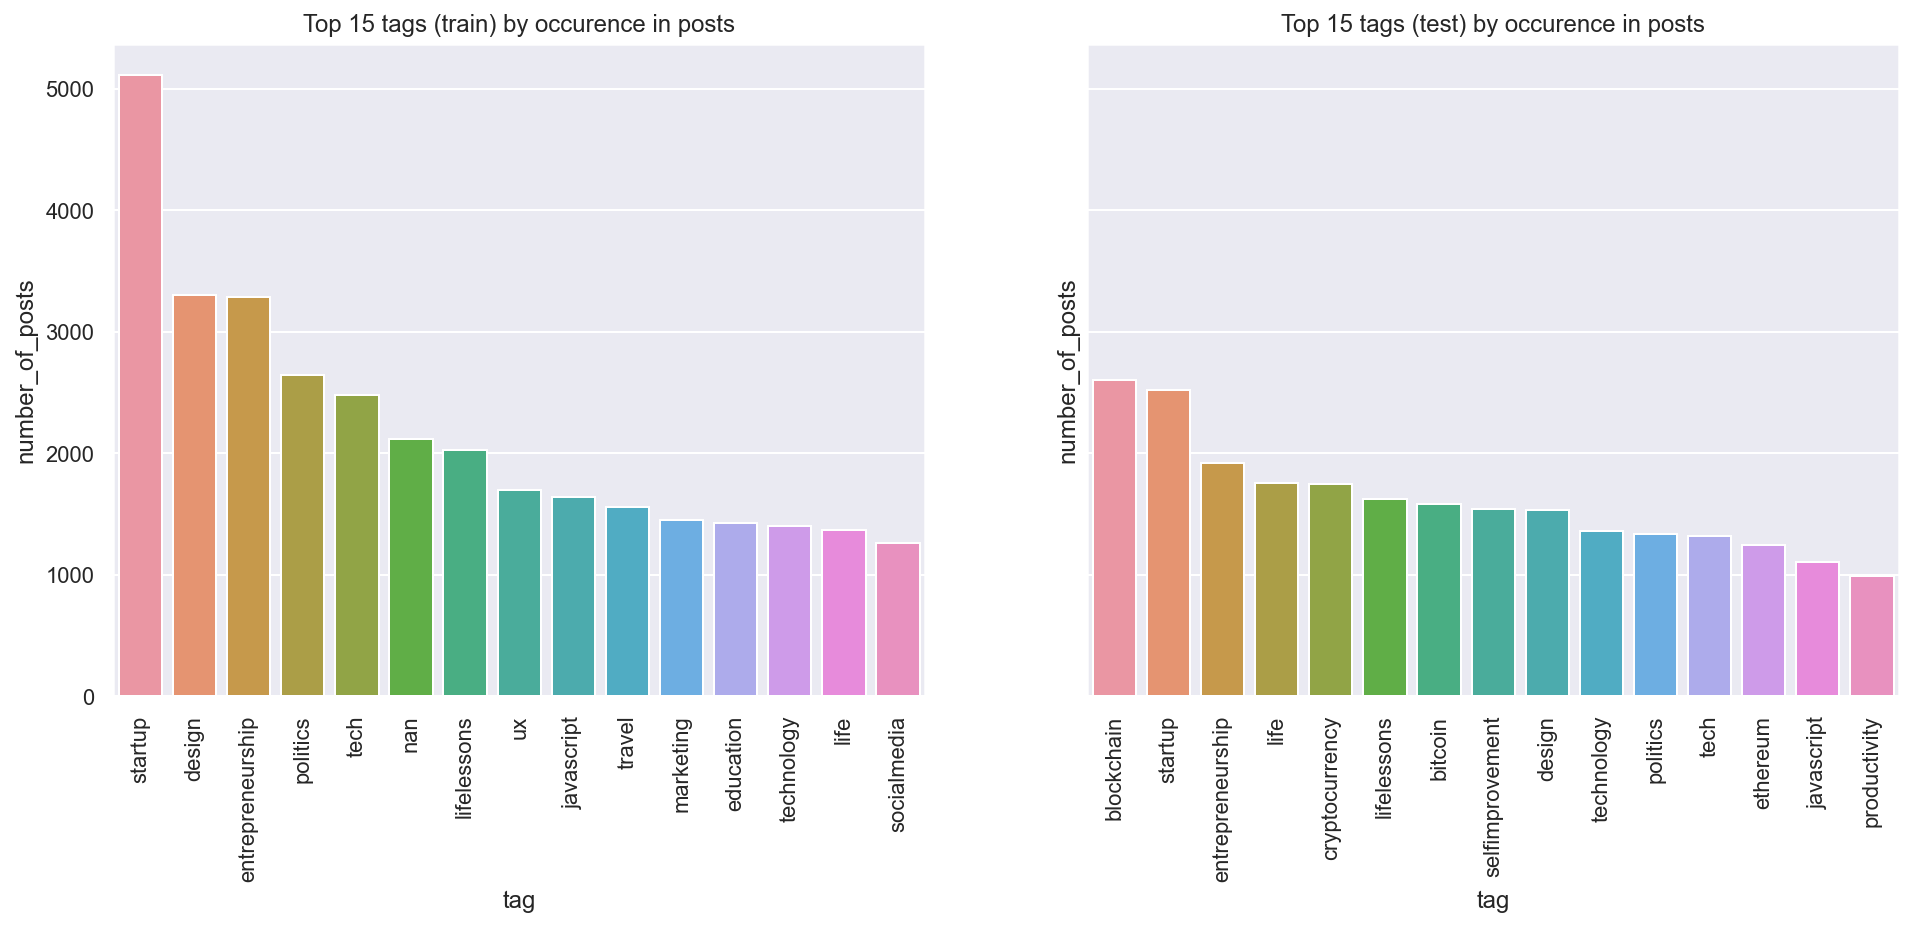

In [253]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.barplot(ax=ax1, x=top15_train_tags.tag, 
            y=top15_train_tags.number_of_posts);
sns.barplot(ax=ax2, x=top15_test_tags.tag, 
            y=top15_test_tags.number_of_posts);

ax1.set_title("Top 15 tags (train) by occurence in posts")
ax2.set_title("Top 15 tags (test) by occurence in posts")
ax1.set_xticklabels(labels=top15_train_tags.tag, rotation=90);
ax2.set_xticklabels(labels=top15_test_tags.tag, rotation=90);

Blockchain and bicoin are getting popular.

In [254]:
top30_train_tags = train_tags_df.sort_values("claps_sum", ascending=False).iloc[:30, [0,3]]

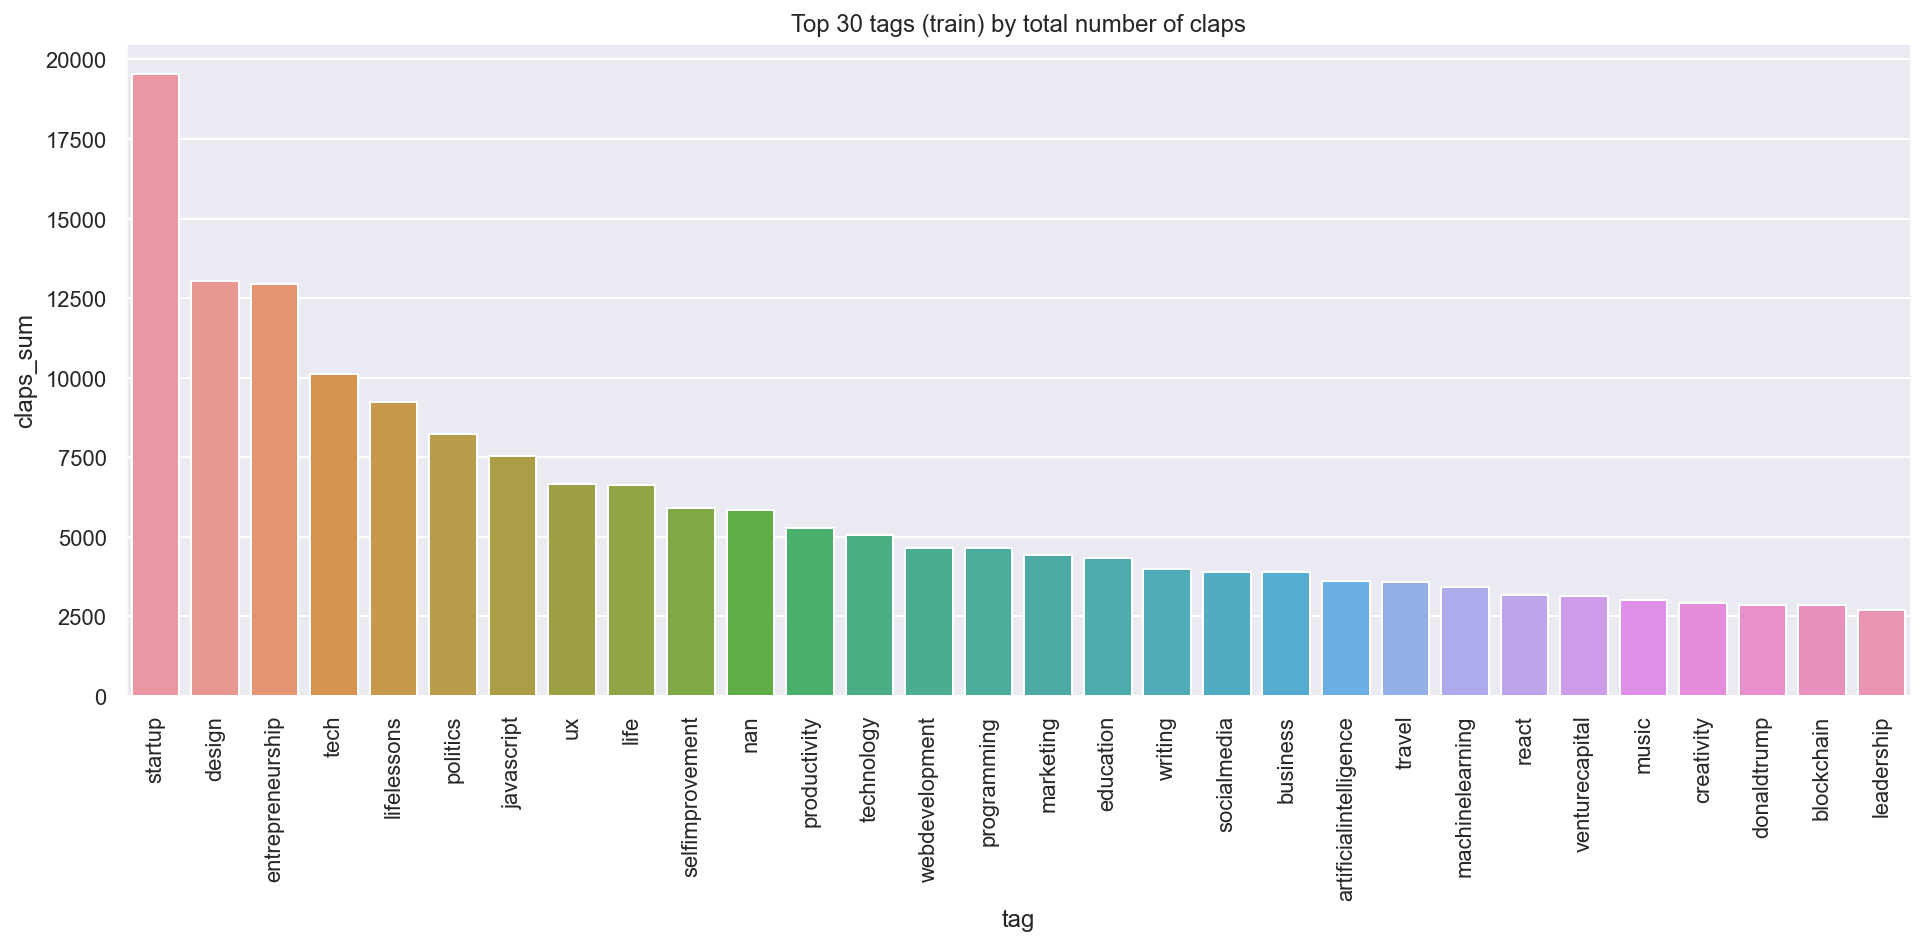

In [255]:
_, ax = plt.subplots(1, 1, sharey=True, figsize=(16,6))

plt.title("Top 30 tags (train) by total number of claps")
sns.barplot(ax=ax, x=top30_train_tags.tag, 
            y=top30_train_tags.claps_sum);

ax.set_xticklabels(labels=top30_train_tags.tag, rotation=90);

In [260]:
top30_train_tags = train_tags_df.sort_values("claps_median", ascending=False).iloc[:30, [0,2]]

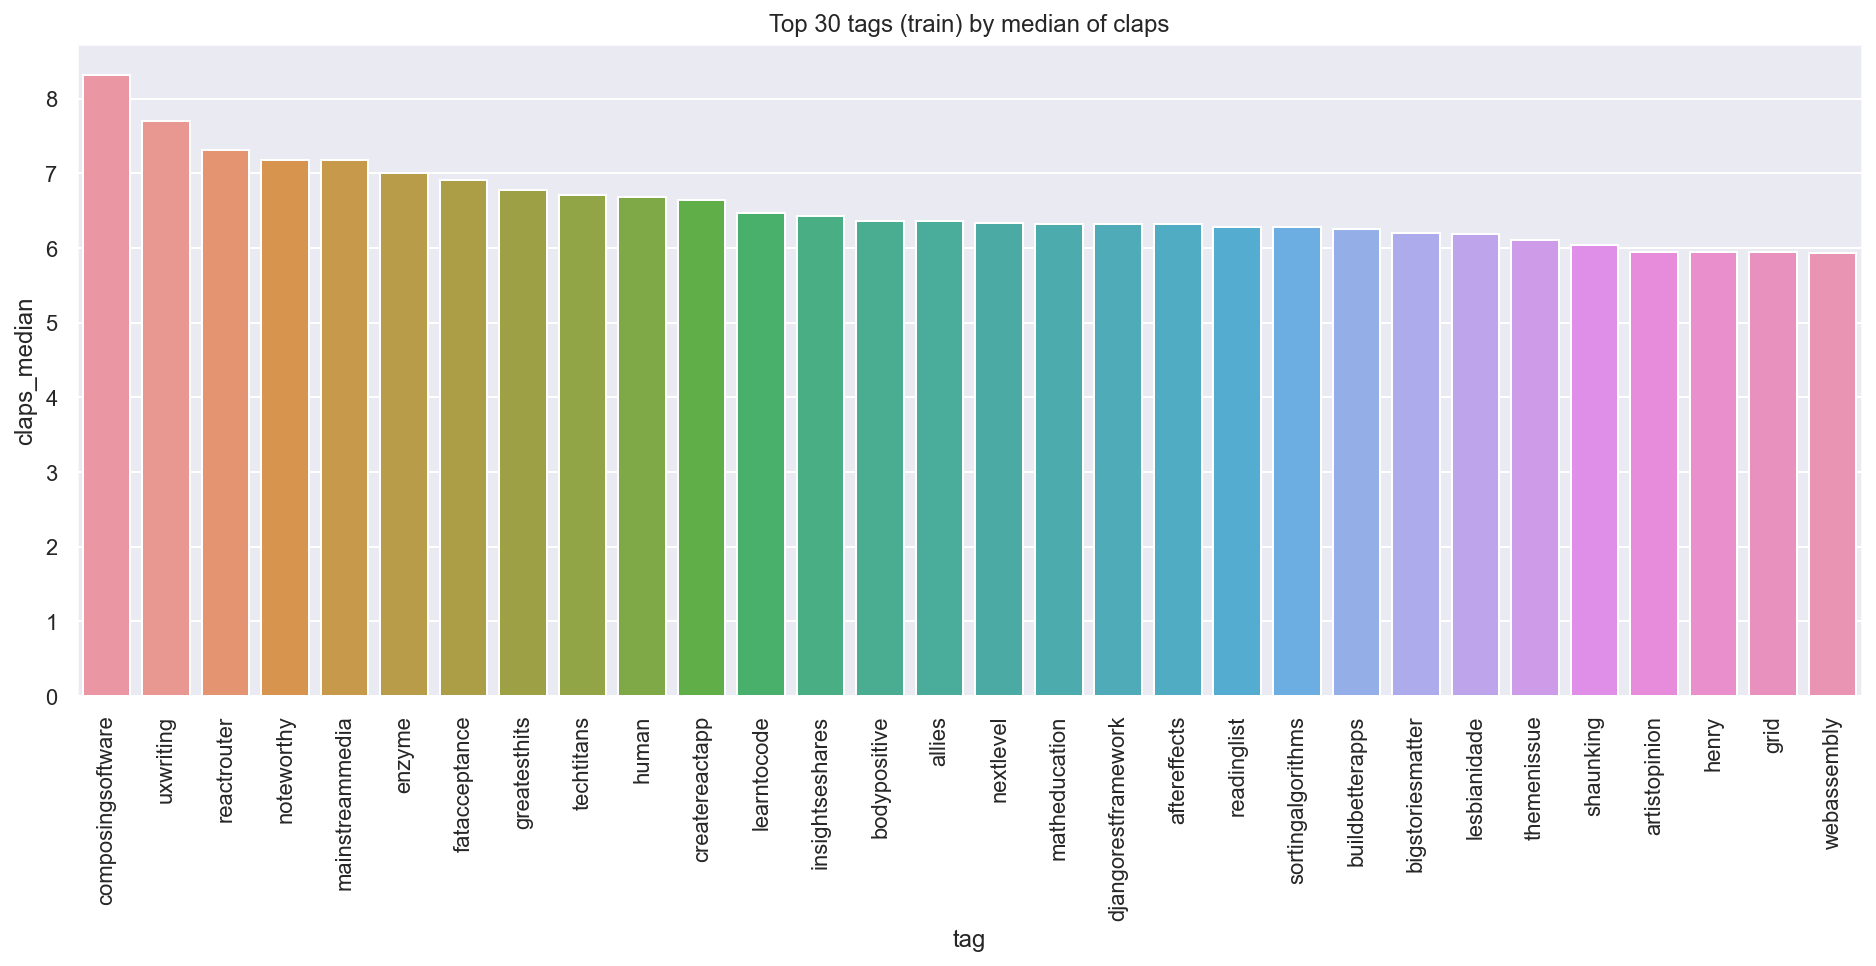

In [262]:
_, ax = plt.subplots(1, 1, sharey=True, figsize=(16,6))

plt.title("Top 30 tags (train) by median of claps")
sns.barplot(ax=ax, x=top30_train_tags.tag, 
            y=top30_train_tags.claps_median);

ax.set_xticklabels(labels=top30_train_tags.tag, rotation=90);

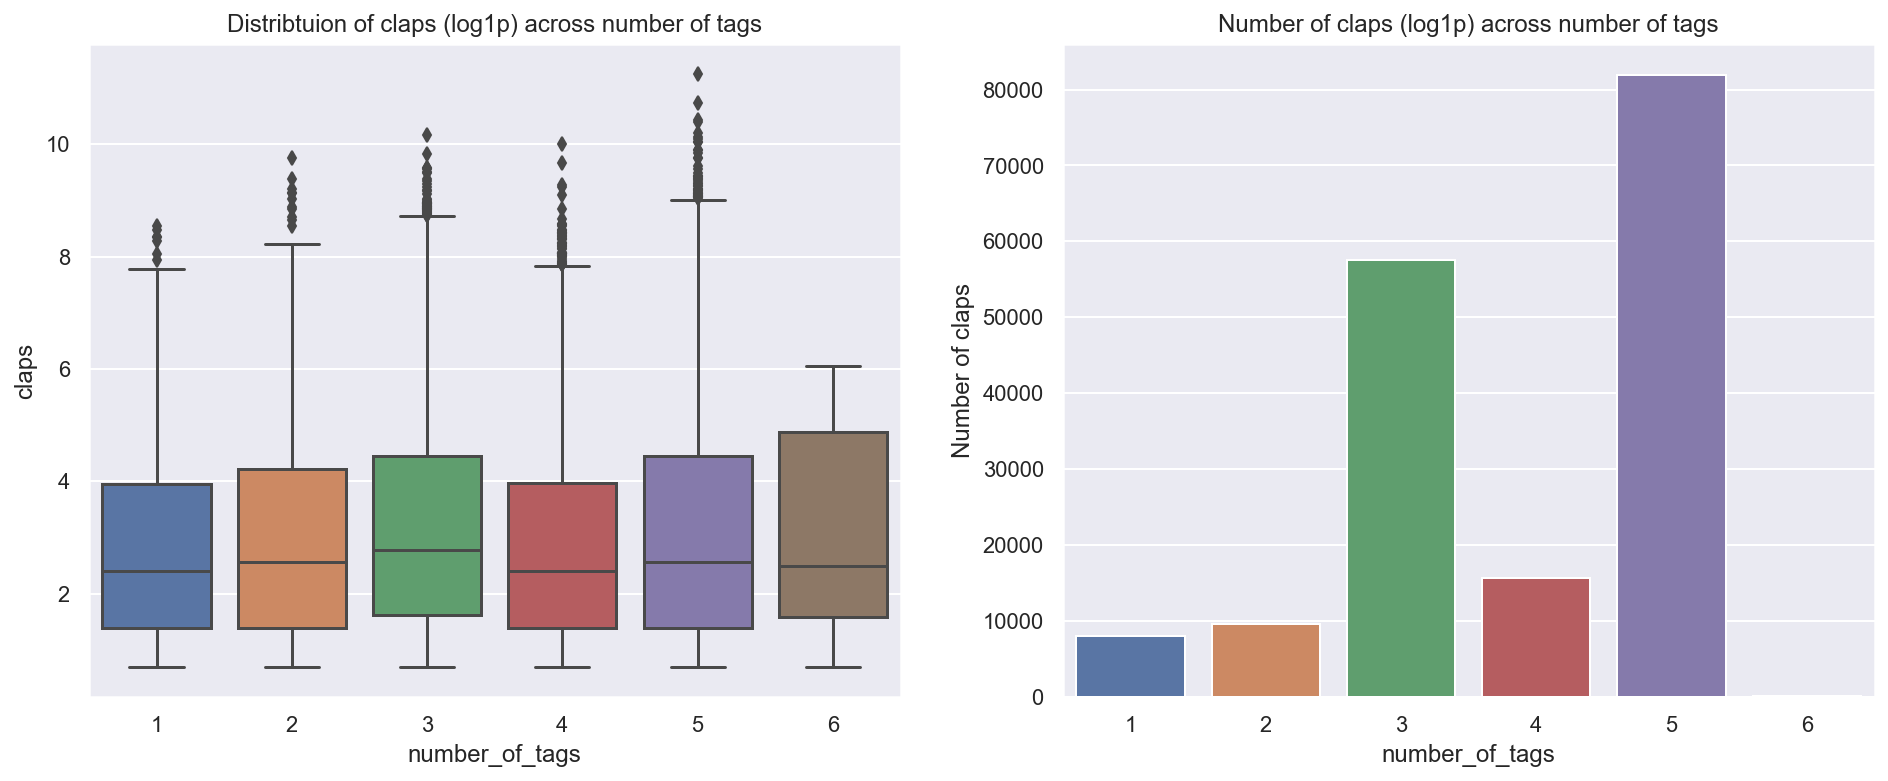

In [283]:
num_tags_claps = train_df_temp.groupby("number_of_tags")["claps"].sum()

box_and_bar_plots(x1 = train_df[train_df.year >= 2015].number_of_tags, x2 = num_tags_claps, 
                  y1 = train_df[train_df.year >= 2015].claps,
                  title1 = "Distribtuion of claps (log1p) across number of tags", 
                  title2 = "Number of claps (log1p) across number of tags", 
                  ylabel2 = "Number of claps")

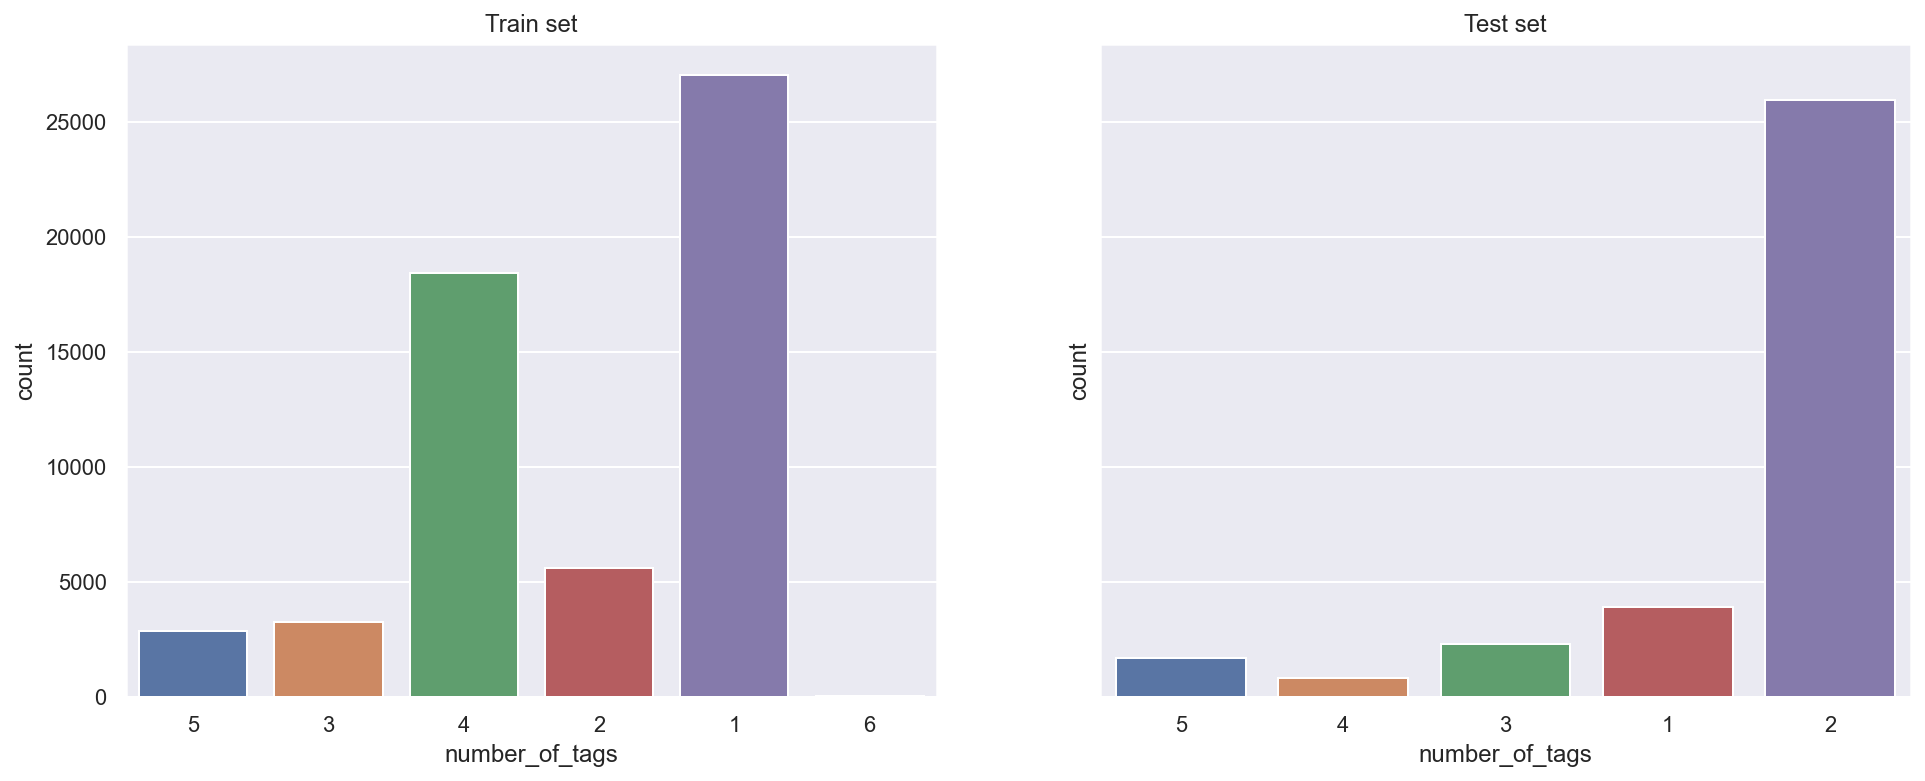

In [287]:
two_count_plots(x1 = train_df[train_df.year >= 2015].number_of_tags, 
                x2 = test_df.number_of_tags,
                title1 = "Train set", title2 = "Test set",
                sharey=True)

## DATA PREPROCESSING

### adding sparse matrices

In [292]:
# Tf-Idf with article content
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

In [291]:
%%time
with open(
    os.path.join(PATH_TO_DATA, "features/train_content.txt"), encoding="utf-8"
) as input_train_file:
    X_train_content_sparse = tfidf_vectorizer.fit_transform(input_train_file)

with open(
    os.path.join(PATH_TO_DATA, "features/test_content.txt"), encoding="utf-8"
) as input_test_file:
    X_test_content_sparse = tfidf_vectorizer.transform(input_test_file)

FileNotFoundError: [Errno 2] No such file or directory: '../data/features/test_content.txt'

In [ ]:
X_train_content_sparse.shape, X_test_content_sparse.shape

**Tf-Idf with titles.**

In [ ]:
%%time
tfidf_vectorizer_title = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)

with open(
    os.path.join(PATH_TO_DATA, "train_title.txt"), encoding="utf-8"
) as input_train_file:
    X_train_title_sparse = tfidf_vectorizer_title.fit_transform(input_train_file)

with open(
    os.path.join(PATH_TO_DATA, "test_title.txt"), encoding="utf-8"
) as input_test_file:
    X_test_title_sparse = tfidf_vectorizer_title.transform(input_test_file)

In [ ]:
X_train_title_sparse.shape, X_test_title_sparse.shape

**Add time features.**

In [ ]:
def add_time_features(path_to_publication_time_file):

    df = pd.read_csv(path_to_publication_time_file, names=["time"])
    df["time"] = df["time"].apply(
        lambda t: pd.to_datetime(t.replace("T", " ").replace("Z", ""))
    )
    df["hour"] = df["time"].apply(lambda ts: ts.hour)
    df["month"] = df["time"].apply(lambda ts: ts.month)

    df["weekend"] = (
        df["time"]
        .apply(lambda ts: ts.weekday() == 5 or ts.weekday() == 6)
        .astype("int")
    )

    df["day"] = ((df["hour"] >= 12) & (df["hour"] <= 18)).astype("int")
    df["morning"] = ((df["hour"] >= 7) & (df["hour"] <= 11)).astype("int")
    df["night"] = ((df["hour"] >= 0) & (df["hour"] <= 5)).astype("int")

    cols = ["day", "morning", "night", "month", "weekend"]
    X_time_features_sparse = csr_matrix(df[cols].values)

    return X_time_features_sparse

In [ ]:
%%time
X_train_time_features_sparse = add_time_features(
    os.path.join(PATH_TO_DATA, "train_published.txt")
)
X_test_time_features_sparse = add_time_features(
    os.path.join(PATH_TO_DATA, "test_published.txt")
)

In [ ]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

**Add authors.**

In [ ]:
%%time
author_train = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_author.txt"),
    names=["author"],
    skip_blank_lines=False,
)
author_train = pd.get_dummies(author_train)

author_test = pd.read_csv(
    os.path.join(PATH_TO_DATA, "test_author.txt"),
    names=["author"],
    skip_blank_lines=False,
)
author_test = pd.get_dummies(author_test)

unique_authors_train = list(set(author_train.columns) - set(author_test.columns))
unique_authors_test = list(set(author_test.columns) - set(author_train.columns))

author_test = author_test.drop(unique_authors_test, axis=1)
author_train = author_train.drop(unique_authors_train, axis=1)

X_train_author_sparse = csr_matrix(author_train.values)
X_test_author_sparse = csr_matrix(author_test.values)

In [ ]:
X_train_author_sparse.shape, X_test_author_sparse.shape

**Join all sparse matrices.**

In [ ]:
X_train_sparse = hstack(
    [
        X_train_content_sparse,
        X_train_title_sparse,
        X_train_author_sparse,
        X_train_time_features_sparse,
    ]
).tocsr()

In [ ]:
X_test_sparse = hstack(
    [
        X_test_content_sparse,
        X_test_title_sparse,
        X_test_author_sparse,
        X_test_time_features_sparse,
    ]
).tocsr()

In [ ]:
X_train_sparse.shape, X_test_sparse.shape

**Read train target and split data for validation.**

In [ ]:
train_target = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_log1p_recommends.csv"), index_col="id"
)
y_train = train_target["log_recommends"].values

In [ ]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse = X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [ ]:
%%time
ridge_reg = Ridge(random_state=17)
ridge_reg.fit(X_train_part_sparse, y_train_part)
ridge_valid_pred = ridge_reg.predict(X_valid_sparse)
print(mean_absolute_error(y_valid, ridge_valid_pred))

Plot distributions of tagets and predictions for the validation set.

In [ ]:
plt.hist(y_valid, bins=30, alpha=0.5, color="red", label="true", range=(0, 10))
plt.hist(
    ridge_valid_pred, bins=30, alpha=0.5, color="green", label="pred", range=(0, 10)
)
plt.legend();

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [ ]:
%%time
ridge_reg.fit(X_train_sparse, y_train)
ridge_test_pred = ridge_reg.predict(X_test_sparse)

In [ ]:
def write_submission_file(
    prediction,
    filename,
    path_to_sample=os.path.join(PATH_TO_DATA, "sample_submission.csv"),
):
    submission = pd.read_csv(path_to_sample, index_col="id")

    submission["log_recommends"] = prediction
    submission.to_csv(filename)

In [ ]:
write_submission_file(
    ridge_test_pred, os.path.join(PATH_TO_DATA, "assignment6_medium_submission.csv")
)

**With this you get ~ 1.73877 on public leaderboard.**

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about? How is it going to help you with modifying your predictions?**

In [ ]:
write_submission_file(
    np.zeros_like(ridge_test_pred),
    os.path.join(PATH_TO_DATA, "medium_all_zeros_submission.csv"),
)

In [ ]:
mean_test_target = 4.33328

**Calculate mean target for the test set.**

In [ ]:
y_train.mean()

**Now we now that we need to add the difference between test and train mean targets.**

In [ ]:
ridge_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [ ]:
write_submission_file(
    ridge_test_pred_modif,
    os.path.join(PATH_TO_DATA, "assignment6_medium_submission_with_hack.csv"),
)

That's it for the assignment. In case you'd like to try some more ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will train much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- And neural nets of course. We don't cover them in this course byt still transformer-based architectures will likely perform well in such types of tasks